In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folder that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]
data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/mat'
#data_directory = '/Users/yardenc/Documents/Experiments/Imaging/Data/CanaryData/lrb853_15/movs/wav/mat'

# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names
data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
# The folder for saving training checkpoints
training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records'
#training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/Data/CanaryData/lrb853_15/training_records'


In [2]:
# Parameters
input_vec_size = 513 #= lstm_size
batch_size = 11
n_lstm_layers = 2
n_syllables = 39 #including zero
learning_rate = 0.001
n_max_iter = 14001
time_steps = 370
window_time_steps = 11

In [3]:
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    
    #First convolutional layers
     # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=tf.reshape(spectrogram,[batch_size,-1,input_vec_size,1]), #time_steps
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 8], strides=[1,8])
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 8], strides=[1,8])
    # Second the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'):
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(lstm_f1,lstm_b1, tf.reshape(pool2,[batch_size,-1,512]), time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Second, projection on the number of syllables creates logits    time_steps
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    expr1 = tf.unstack(outputs[0],axis=0,num=batch_size)
    expr2 = tf.unstack(outputs[1],axis=0,num=batch_size)
    #logits = [tf.matmul(outputs[0][:,a,:],W_f) + bias + tf.matmul(outputs[1][:,a,:],W_b) for a in range(seq_length[0])]
    logits = tf.concat([tf.matmul(ex1,W_f) + bias + tf.matmul(ex2,W_b) for ex1,ex2 in zip(expr1,expr2)],0)
    return logits,outputs

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, lbls, rate, lng):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.concat(tf.unstack(lbls,axis=0,num=batch_size),0), name='xentropy')
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
        # Generate placeholders for the spectrograms and labels.
        X = tf.placeholder("float", [None,None,input_vec_size], name = "Xdata") # holds spectrograms batch_size,time_steps
        Y = tf.placeholder("int32",[None,None],name = "Ylabels") # holds labels batch_size
        lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
        tf.add_to_collection("specs", X)  # Remember this Op.
        tf.add_to_collection("labels", Y)  # Remember this Op.
        tf.add_to_collection("lng", lng)  # Remember this Op.
        # Build a Graph that computes predictions from the inference model.
        logits,outputs = label_inference_graph(X, 512, n_lstm_layers, lng) #lstm_size
        tf.add_to_collection("logits", logits)  # Remember this Op.

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op, cost = training_graph(logits, Y, learning_rate, lng)

        # Add the variable initializer Op.
        init = tf.global_variables_initializer() #initialize_all_variables()

        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver(max_to_keep = 10)

In [6]:
# Prepare training dataset
# Go over all training files and load data
file_num = 0
fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
data = cpio.loadmat(data_directory + '/' + fname)
data1 = np.transpose(data['s'])
intY = data['labels'][0]
for file_num in range(number_of_files-1):
    # load current training file
    fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
    bdata = cpio.loadmat(data_directory + '/' + fname)
    bdata1 = np.transpose(bdata['s'])
    bintY = bdata['labels'][0]
    data1 = np.concatenate((data1,bdata1),axis = 0)
    intY = np.concatenate((intY,bintY),axis = 0)
print 'Original dataset shape: '+ str(data1.shape)
temp_n = len(intY)/batch_size
data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
iter_order = np.random.permutation(data1.shape[1]-time_steps)
if (len(iter_order) > n_max_iter):
    iter_order = iter_order[0:n_max_iter]
print 'Training dataset shape: ' + str(data1.shape) +', #iterations: ' + str(len(iter_order))

Original dataset shape: (144271, 513)
Training dataset shape: (11, 13115, 513), #iterations: 12745


In [7]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph,config = tf.ConfigProto(intra_op_parallelism_threads = 512)) as sess:
    #,config = tf.ConfigProto(intra_op_parallelism_threads = 1)
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1  
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+time_steps,:] ,Y: intY[:,iternum:iternum+time_steps] ,lng:[time_steps]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
        if (step % 100 == 0):
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
        

[1, 9561, 3.491401]
[2, 11949, 3.5257061]
[3, 9579, 2.644691]
[4, 144, 2.729562]
[5, 1325, 2.3718717]
[6, 5854, 2.432842]
[7, 788, 2.331239]
[8, 8150, 3.1752756]
[9, 3204, 2.7483616]
[10, 7103, 2.0489147]
[11, 4699, 2.1868889]
[12, 5592, 2.439492]
[13, 6567, 1.9318352]
[14, 5433, 1.8852839]
[15, 5644, 1.7234647]
[16, 3272, 2.035404]
[17, 5961, 1.543455]
[18, 8853, 1.8066864]
[19, 8537, 1.9181536]
[20, 983, 1.2602131]
[21, 9171, 1.4773612]
[22, 5037, 1.4782478]
[23, 2467, 1.8980243]
[24, 10457, 1.4315524]
[25, 6392, 0.85049993]
[26, 2623, 1.5496517]
[27, 3643, 1.7748772]
[28, 9451, 1.1879307]
[29, 9858, 1.1388494]
[30, 12281, 1.2385074]
[31, 4966, 1.0611953]
[32, 8044, 2.0810685]
[33, 9992, 1.0057461]
[34, 4943, 0.75321823]
[35, 3422, 1.6283247]
[36, 8029, 0.89909351]
[37, 4781, 0.96506143]
[38, 7602, 0.78927141]
[39, 2930, 1.4360909]
[40, 6894, 1.8755648]
[41, 8522, 1.0593334]
[42, 3530, 1.2684023]
[43, 7224, 0.90628719]
[44, 12461, 1.3116889]
[45, 4483, 1.2168767]
[46, 5472, 1.108057]

[348, 8796, 0.21885608]
[349, 413, 0.48638994]
[350, 10333, 0.25926569]
[351, 10327, 0.2564595]
[352, 3368, 0.4738363]
[353, 1641, 0.25939563]
[354, 5919, 0.16529007]
[355, 6330, 0.1380925]
[356, 4277, 0.25015572]
[357, 6653, 0.21682183]
[358, 5015, 0.18797667]
[359, 4794, 0.23233831]
[360, 10027, 0.2042255]
[361, 8978, 0.34100896]
[362, 12732, 0.98805714]
[363, 4829, 0.15831761]
[364, 8943, 0.23094054]
[365, 4062, 0.21528161]
[366, 4314, 0.14425223]
[367, 5662, 0.12969108]
[368, 4885, 0.16850446]
[369, 9993, 0.29235539]
[370, 3740, 0.25216654]
[371, 7919, 0.15503453]
[372, 8715, 0.21089928]
[373, 10645, 0.38114297]
[374, 7382, 0.18414445]
[375, 10126, 0.12524694]
[376, 6525, 0.14926213]
[377, 7592, 0.16995864]
[378, 8879, 0.1836976]
[379, 3456, 0.18666178]
[380, 10357, 0.22225526]
[381, 6845, 0.26917133]
[382, 9647, 0.14415359]
[383, 6722, 0.20082201]
[384, 2901, 0.34179285]
[385, 12206, 0.30897164]
[386, 3945, 0.17929828]
[387, 2457, 0.20757079]
[388, 480, 0.13203299]
[389, 3744, 0.1

[686, 8453, 0.12219848]
[687, 555, 0.056593526]
[688, 8785, 0.31509283]
[689, 10772, 0.09171702]
[690, 10684, 0.12408797]
[691, 7529, 0.115581]
[692, 9581, 0.065830059]
[693, 1021, 0.070410155]
[694, 7849, 0.095600404]
[695, 3031, 0.22711436]
[696, 12547, 0.49725404]
[697, 2798, 0.14938094]
[698, 8167, 0.079419181]
[699, 12341, 0.18336539]
0.158298
[700, 8772, 0.25079095]
[701, 11672, 0.24202427]
[702, 7846, 0.099559456]
[703, 9258, 0.12359751]
[704, 4697, 0.12528616]
[705, 12425, 0.14174846]
[706, 5734, 0.18823825]
[707, 7701, 0.22836056]
[708, 4418, 0.15409285]
[709, 10817, 0.10823032]
[710, 5296, 0.082359426]
[711, 8769, 0.30787909]
[712, 4581, 0.15246226]
[713, 1165, 0.11309171]
[714, 5042, 0.1043902]
[715, 11765, 0.13936552]
[716, 7743, 0.099298328]
[717, 7007, 0.16642745]
[718, 7105, 0.12330751]
[719, 8761, 0.14099601]
[720, 11970, 0.14614487]
[721, 3545, 0.1683768]
[722, 4343, 0.12044016]
[723, 12346, 0.23475482]
[724, 9389, 0.086621627]
[725, 7912, 0.10090209]
[726, 9349, 0.086

[1019, 6994, 0.098350942]
[1020, 12261, 0.14216018]
[1021, 7634, 0.064453453]
[1022, 7881, 0.072579771]
[1023, 365, 0.11535905]
[1024, 5691, 0.069324479]
[1025, 11331, 0.084929183]
[1026, 4582, 0.11556725]
[1027, 11828, 0.20446463]
[1028, 10160, 0.10017572]
[1029, 12650, 0.13583319]
[1030, 6546, 0.10355908]
[1031, 5350, 0.056024805]
[1032, 2764, 0.123361]
[1033, 218, 0.15155236]
[1034, 768, 0.043010317]
[1035, 3986, 0.10499324]
[1036, 4386, 0.067626514]
[1037, 10641, 0.16131529]
[1038, 5055, 0.092120141]
[1039, 12696, 0.10520416]
[1040, 12286, 0.12855212]
[1041, 2046, 0.10677589]
[1042, 9670, 0.078431182]
[1043, 1442, 0.19386491]
[1044, 7037, 0.12249512]
[1045, 5356, 0.094886772]
[1046, 11502, 0.092813328]
[1047, 1628, 0.086852975]
[1048, 9069, 0.18514387]
[1049, 12640, 0.15790933]
[1050, 10225, 0.10834093]
[1051, 8529, 0.093739994]
[1052, 11922, 0.14624879]
[1053, 4225, 0.10092793]
[1054, 9262, 0.066699371]
[1055, 7368, 0.10230488]
[1056, 10460, 0.11774909]
[1057, 3973, 0.11996721]
[1

[1339, 2363, 0.09719225]
[1340, 8407, 0.076046348]
[1341, 7568, 0.061416544]
[1342, 6974, 0.062556103]
[1343, 9879, 0.054552484]
[1344, 5659, 0.061534427]
[1345, 6248, 0.050434075]
[1346, 2870, 0.12843847]
[1347, 2474, 0.079047956]
[1348, 7493, 0.073534742]
[1349, 12011, 0.10982442]
[1350, 622, 0.036338277]
[1351, 11743, 0.08299543]
[1352, 6471, 0.056327768]
[1353, 11048, 0.063340493]
[1354, 10741, 0.18594338]
[1355, 7945, 0.069959164]
[1356, 5359, 0.052774463]
[1357, 5516, 0.065561622]
[1358, 11537, 0.067091316]
[1359, 6683, 0.08980529]
[1360, 11024, 0.04724738]
[1361, 1816, 0.10818792]
[1362, 6550, 0.054219812]
[1363, 7307, 0.068590358]
[1364, 4877, 0.088288069]
[1365, 421, 0.066947713]
[1366, 7582, 0.075081818]
[1367, 8557, 0.080945224]
[1368, 12676, 0.11584158]
[1369, 4210, 0.10744832]
[1370, 11911, 0.075259931]
[1371, 7622, 0.063915014]
[1372, 9751, 0.061725996]
[1373, 11504, 0.059391886]
[1374, 3730, 0.09548334]
[1375, 5422, 0.053858541]
[1376, 3046, 0.1474995]
[1377, 11154, 0.08

[1656, 6085, 0.052336108]
[1657, 3685, 0.090855472]
[1658, 3036, 0.20801441]
[1659, 5744, 0.06961257]
[1660, 1772, 0.062988237]
[1661, 9362, 0.067969151]
[1662, 11809, 0.12608907]
[1663, 6299, 0.073626325]
[1664, 10712, 0.05573006]
[1665, 11310, 0.074169025]
[1666, 5077, 0.072678812]
[1667, 7384, 0.083742172]
[1668, 12137, 0.089926623]
[1669, 5181, 0.072033592]
[1670, 6595, 0.18118246]
[1671, 11135, 0.056706615]
[1672, 3164, 0.14484903]
[1673, 12580, 0.22527382]
[1674, 6254, 0.053734045]
[1675, 3904, 0.13415743]
[1676, 8010, 0.071939141]
[1677, 1561, 0.124646]
[1678, 2503, 0.10541593]
[1679, 1107, 0.10466798]
[1680, 5883, 0.080455646]
[1681, 10973, 0.050147936]
[1682, 10602, 0.071721777]
[1683, 9998, 0.069575682]
[1684, 3147, 0.28082779]
[1685, 4480, 0.11452113]
[1686, 7004, 0.2679154]
[1687, 7878, 0.094349787]
[1688, 7635, 0.084237747]
[1689, 11330, 0.077685028]
[1690, 11801, 0.10076991]
[1691, 8281, 0.095381245]
[1692, 4411, 0.058238063]
[1693, 2898, 0.11011983]
[1694, 11448, 0.32798

[1973, 12231, 0.067803793]
[1974, 12502, 0.10833382]
[1975, 3669, 0.089143693]
[1976, 7873, 0.13907252]
[1977, 7375, 0.067267492]
[1978, 1978, 0.071245313]
[1979, 2335, 0.068764769]
[1980, 9910, 0.18590511]
[1981, 1246, 0.092508726]
[1982, 6156, 0.048736405]
[1983, 1252, 0.069002323]
[1984, 1577, 0.06624648]
[1985, 10748, 0.065787181]
[1986, 3525, 0.07765986]
[1987, 11512, 0.076903448]
[1988, 8891, 0.13914888]
[1989, 3670, 0.071442753]
[1990, 794, 0.031115646]
[1991, 4758, 0.15926991]
[1992, 9795, 0.11648007]
[1993, 5159, 0.060329333]
[1994, 10953, 0.043569282]
[1995, 6945, 0.051700421]
[1996, 3010, 0.13741325]
[1997, 1508, 0.16442554]
[1998, 6820, 0.088693589]
[1999, 5891, 0.10030977]
0.0947774
[2000, 5720, 0.071527831]
[2001, 3371, 0.10450242]
[2002, 8341, 0.094119191]
[2003, 5366, 0.04037727]
[2004, 11109, 0.090864018]
[2005, 5996, 0.088289678]
[2006, 9746, 0.073821627]
[2007, 7960, 0.074834846]
[2008, 5387, 0.043472383]
[2009, 8534, 0.09431915]
[2010, 10688, 0.071020536]
[2011, 148

[2288, 12717, 0.049336035]
[2289, 5882, 0.052829806]
[2290, 12179, 0.066196702]
[2291, 4353, 0.076489709]
[2292, 11067, 0.052368037]
[2293, 5308, 0.083628006]
[2294, 4745, 0.087140456]
[2295, 12608, 0.044962145]
[2296, 163, 0.057242624]
[2297, 1468, 0.084616914]
[2298, 9289, 0.073931843]
[2299, 6490, 0.056535032]
0.0696196
[2300, 7680, 0.057757553]
[2301, 7038, 0.04344184]
[2302, 1250, 0.056051306]
[2303, 2589, 0.070566438]
[2304, 671, 0.038505752]
[2305, 1208, 0.051771153]
[2306, 7223, 0.051737737]
[2307, 4741, 0.055710785]
[2308, 3388, 0.076244794]
[2309, 6527, 0.040283088]
[2310, 2682, 0.052812997]
[2311, 7506, 0.048003726]
[2312, 9085, 0.10469315]
[2313, 2262, 0.05977295]
[2314, 1746, 0.068284042]
[2315, 10394, 0.074091807]
[2316, 10969, 0.046933532]
[2317, 12473, 0.17789945]
[2318, 8975, 0.078594156]
[2319, 7669, 0.073116317]
[2320, 7721, 0.074149013]
[2321, 4396, 0.070081331]
[2322, 6558, 0.068676688]
[2323, 751, 0.07040631]
[2324, 7158, 0.074275702]
[2325, 7723, 0.1003447]
[2326

[2602, 1058, 0.049929086]
[2603, 4730, 0.052749988]
[2604, 8532, 0.06776312]
[2605, 10362, 0.056004677]
[2606, 5830, 0.05108083]
[2607, 9636, 0.048526138]
[2608, 9999, 0.048900742]
[2609, 5646, 0.046752293]
[2610, 9584, 0.036657147]
[2611, 8082, 0.059156548]
[2612, 6950, 0.052112039]
[2613, 3152, 0.12500258]
[2614, 3869, 0.081344701]
[2615, 1802, 0.056723535]
[2616, 9402, 0.04365918]
[2617, 8324, 0.064265899]
[2618, 11488, 0.044596206]
[2619, 9691, 0.047461454]
[2620, 11960, 0.082093336]
[2621, 7730, 0.0687645]
[2622, 11466, 0.042753]
[2623, 1891, 0.06788668]
[2624, 649, 0.018090153]
[2625, 214, 0.048608951]
[2626, 6725, 0.04937318]
[2627, 5330, 0.031922918]
[2628, 6055, 0.051800117]
[2629, 11570, 0.044142436]
[2630, 12431, 0.044386566]
[2631, 8554, 0.057829183]
[2632, 1882, 0.060203098]
[2633, 4271, 0.077099554]
[2634, 6671, 0.05088526]
[2635, 3933, 0.066219561]
[2636, 896, 0.034183335]
[2637, 6608, 0.055286683]
[2638, 4512, 0.048869189]
[2639, 3627, 0.046226613]
[2640, 501, 0.0247223

[2917, 4997, 0.057655159]
[2918, 2084, 0.052494947]
[2919, 12224, 0.06604486]
[2920, 3468, 0.056007508]
[2921, 11881, 0.068304174]
[2922, 2556, 0.054824557]
[2923, 2325, 0.046174556]
[2924, 7049, 0.039863303]
[2925, 8119, 0.052478161]
[2926, 6109, 0.058310848]
[2927, 2121, 0.051496606]
[2928, 8305, 0.052491762]
[2929, 9183, 0.063573495]
[2930, 12258, 0.051702969]
[2931, 2360, 0.052046519]
[2932, 3862, 0.056602698]
[2933, 6295, 0.039435837]
[2934, 1755, 0.049312346]
[2935, 1560, 0.050517607]
[2936, 12292, 0.045950703]
[2937, 4902, 0.063725814]
[2938, 3327, 0.072788164]
[2939, 12237, 0.038761929]
[2940, 5624, 0.0450783]
[2941, 12708, 0.065440439]
[2942, 6859, 0.048534852]
[2943, 7410, 0.067315117]
[2944, 10178, 0.04329142]
[2945, 11169, 0.040281728]
[2946, 12316, 0.036844976]
[2947, 11445, 0.049023621]
[2948, 7152, 0.040509783]
[2949, 7863, 0.055732392]
[2950, 9239, 0.045367852]
[2951, 11701, 0.042933267]
[2952, 10469, 0.056729317]
[2953, 4765, 0.049830496]
[2954, 2240, 0.05041955]
[2955

[3234, 212, 0.31132278]
[3235, 11018, 0.15466404]
[3236, 3020, 0.12633137]
[3237, 1290, 0.14503554]
[3238, 10941, 0.037210677]
[3239, 8508, 0.076223679]
[3240, 9254, 0.067170113]
[3241, 12192, 0.078421935]
[3242, 10885, 0.030792501]
[3243, 10783, 0.033199754]
[3244, 4421, 0.04890506]
[3245, 8327, 0.064803191]
[3246, 6539, 0.056273572]
[3247, 12494, 0.076700829]
[3248, 7348, 0.062805101]
[3249, 2603, 0.064691663]
[3250, 8005, 0.061306462]
[3251, 10782, 0.031857703]
[3252, 470, 0.048836064]
[3253, 9173, 0.061707418]
[3254, 4613, 0.075401984]
[3255, 216, 0.041869339]
[3256, 9086, 0.078717925]
[3257, 9611, 0.06165408]
[3258, 222, 0.037004918]
[3259, 8246, 0.064977922]
[3260, 7612, 0.055796426]
[3261, 4660, 0.059817724]
[3262, 5150, 0.043497503]
[3263, 12457, 0.053557962]
[3264, 8965, 0.078066908]
[3265, 4637, 0.046079934]
[3266, 4003, 0.095034458]
[3267, 11264, 0.061409518]
[3268, 7858, 0.056656789]
[3269, 5124, 0.043078873]
[3270, 8084, 0.05777077]
[3271, 8302, 0.062798247]
[3272, 6618, 0

[3549, 2242, 0.04717093]
[3550, 2070, 0.045989141]
[3551, 5476, 0.029150072]
[3552, 1245, 0.043524757]
[3553, 3747, 0.051731527]
[3554, 4731, 0.053896233]
[3555, 7809, 0.06006119]
[3556, 2575, 0.035616279]
[3557, 10455, 0.045316759]
[3558, 5987, 0.040806103]
[3559, 2424, 0.042811081]
[3560, 4864, 0.044371217]
[3561, 210, 0.039417412]
[3562, 4328, 0.043311637]
[3563, 5101, 0.029950354]
[3564, 2295, 0.04026372]
[3565, 6921, 0.078561902]
[3566, 10167, 0.060268648]
[3567, 7021, 0.040905863]
[3568, 2761, 0.046499211]
[3569, 4046, 0.062029075]
[3570, 5878, 0.045294076]
[3571, 10208, 0.049234346]
[3572, 231, 0.033686724]
[3573, 12017, 0.063236617]
[3574, 861, 0.024333781]
[3575, 2171, 0.050666507]
[3576, 12674, 0.05302415]
[3577, 2975, 0.10754602]
[3578, 9686, 0.040491246]
[3579, 5964, 0.041339178]
[3580, 8444, 0.054942433]
[3581, 6373, 0.037427384]
[3582, 7444, 0.049764853]
[3583, 2686, 0.037708659]
[3584, 3751, 0.095321886]
[3585, 615, 0.01520412]
[3586, 2555, 0.057032123]
[3587, 12428, 0.0

[3864, 8151, 0.043050371]
[3865, 10057, 0.048350595]
[3866, 9004, 0.041223004]
[3867, 9651, 0.035876408]
[3868, 5512, 0.030807944]
[3869, 7372, 0.047589]
[3870, 5884, 0.046170827]
[3871, 7709, 0.048620787]
[3872, 12090, 0.051754441]
[3873, 4499, 0.039767023]
[3874, 5739, 0.033596989]
[3875, 7288, 0.03998832]
[3876, 10351, 0.047812849]
[3877, 8418, 0.069403291]
[3878, 5467, 0.020104647]
[3879, 3011, 0.076370075]
[3880, 1228, 0.039302677]
[3881, 12210, 0.036974877]
[3882, 10673, 0.021937428]
[3883, 2908, 0.04187407]
[3884, 4549, 0.033764131]
[3885, 12256, 0.037796829]
[3886, 2422, 0.041823737]
[3887, 6489, 0.042595923]
[3888, 8664, 0.041813962]
[3889, 8318, 0.045286611]
[3890, 5304, 0.035304703]
[3891, 6100, 0.04020118]
[3892, 1443, 0.048039291]
[3893, 1054, 0.038924128]
[3894, 6, 0.06355875]
[3895, 5737, 0.030534502]
[3896, 9517, 0.038120274]
[3897, 12591, 0.04841261]
[3898, 4309, 0.05813814]
[3899, 3864, 0.058766786]
0.0445815
[3900, 10101, 0.05027093]
[3901, 10867, 0.025780726]
[3902,

[4178, 3784, 0.041058034]
[4179, 11614, 0.048018184]
[4180, 3721, 0.029563513]
[4181, 544, 0.014843754]
[4182, 4547, 0.046285972]
[4183, 3294, 0.069269851]
[4184, 6280, 0.032922629]
[4185, 4672, 0.040282868]
[4186, 3060, 0.048690811]
[4187, 11127, 0.042529427]
[4188, 10634, 0.021430239]
[4189, 11525, 0.031091444]
[4190, 6005, 0.04261769]
[4191, 1654, 0.056962963]
[4192, 1362, 0.04886565]
[4193, 8278, 0.046847947]
[4194, 12432, 0.042251978]
[4195, 8129, 0.03746444]
[4196, 1565, 0.031511463]
[4197, 11562, 0.035383373]
[4198, 4282, 0.052161306]
[4199, 1535, 0.032999691]
0.0437852
[4200, 1013, 0.039647721]
[4201, 1808, 0.036514893]
[4202, 5395, 0.018564923]
[4203, 7138, 0.053061202]
[4204, 7250, 0.05513471]
[4205, 8882, 0.040779606]
[4206, 1007, 0.026885772]
[4207, 5143, 0.029720664]
[4208, 11292, 0.047788497]
[4209, 3215, 0.063150905]
[4210, 9627, 0.037617512]
[4211, 9064, 0.040093966]
[4212, 6163, 0.034688026]
[4213, 4806, 0.041762631]
[4214, 12601, 0.043050885]
[4215, 6115, 0.027747143]

[4492, 6856, 0.032677196]
[4493, 11285, 0.070707612]
[4494, 1546, 0.045400243]
[4495, 8799, 0.040886756]
[4496, 709, 0.012466061]
[4497, 3130, 0.078041568]
[4498, 3735, 0.054416593]
[4499, 8428, 0.048643135]
0.0445637
[4500, 8675, 0.04468235]
[4501, 4257, 0.033672042]
[4502, 1864, 0.088710874]
[4503, 7003, 0.036488112]
[4504, 6597, 0.04214067]
[4505, 6450, 0.034707699]
[4506, 3001, 0.053631525]
[4507, 1580, 0.03883015]
[4508, 7093, 0.032277118]
[4509, 8883, 0.064676896]
[4510, 1331, 0.037201934]
[4511, 4648, 0.056041118]
[4512, 1251, 0.035642676]
[4513, 7633, 0.038446061]
[4514, 9125, 0.038302541]
[4515, 7363, 0.033393398]
[4516, 355, 0.026568599]
[4517, 3861, 0.045248147]
[4518, 1706, 0.040456899]
[4519, 4908, 0.049331632]
[4520, 12299, 0.058200702]
[4521, 2545, 0.060730785]
[4522, 1022, 0.031481534]
[4523, 12, 0.053747937]
[4524, 11000, 0.029013894]
[4525, 8363, 0.049359262]
[4526, 10392, 0.058894616]
[4527, 5052, 0.05086121]
[4528, 5868, 0.068464704]
[4529, 6792, 0.037920661]
[4530,

[4806, 8256, 0.028996008]
[4807, 8452, 0.033604745]
[4808, 5121, 0.033122141]
[4809, 9698, 0.041348126]
[4810, 10944, 0.017399147]
[4811, 1544, 0.038698833]
[4812, 4076, 0.045553152]
[4813, 7914, 0.035864186]
[4814, 5801, 0.0328191]
[4815, 2141, 0.03011738]
[4816, 4723, 0.047782164]
[4817, 7927, 0.033798132]
[4818, 963, 0.028714458]
[4819, 5017, 0.028206272]
[4820, 11936, 0.041770436]
[4821, 11176, 0.02868822]
[4822, 450, 0.014342204]
[4823, 9534, 0.043035846]
[4824, 11363, 0.049289029]
[4825, 4691, 0.033734046]
[4826, 1287, 0.035602186]
[4827, 4245, 0.036985748]
[4828, 1171, 0.030575702]
[4829, 729, 0.011174114]
[4830, 10595, 0.01823917]
[4831, 10032, 0.058537483]
[4832, 1898, 0.045744643]
[4833, 10747, 0.01636932]
[4834, 8389, 0.041827194]
[4835, 56, 0.033567078]
[4836, 2265, 0.047270413]
[4837, 9758, 0.038825579]
[4838, 1715, 0.029106209]
[4839, 12202, 0.032156415]
[4840, 1342, 0.031900425]
[4841, 1249, 0.031831332]
[4842, 11460, 0.036082763]
[4843, 3976, 0.067053996]
[4844, 11167, 

[5122, 8260, 0.034640174]
[5123, 9133, 0.026726868]
[5124, 3061, 0.0318169]
[5125, 5956, 0.030166751]
[5126, 11123, 0.02967073]
[5127, 3823, 0.045481171]
[5128, 3287, 0.049177241]
[5129, 9643, 0.036462933]
[5130, 6876, 0.019617165]
[5131, 2038, 0.031283062]
[5132, 575, 0.0095180357]
[5133, 4901, 0.032422803]
[5134, 11449, 0.038301814]
[5135, 1611, 0.028223388]
[5136, 2074, 0.025913086]
[5137, 5901, 0.029506264]
[5138, 11684, 0.026667025]
[5139, 3335, 0.04597804]
[5140, 2564, 0.039918248]
[5141, 2152, 0.027813535]
[5142, 7569, 0.033521548]
[5143, 191, 0.02338521]
[5144, 9696, 0.027059978]
[5145, 4023, 0.039343596]
[5146, 8602, 0.029923454]
[5147, 12334, 0.039160375]
[5148, 556, 0.0075011728]
[5149, 11098, 0.021988934]
[5150, 3183, 0.04640549]
[5151, 8842, 0.02872478]
[5152, 11686, 0.017575013]
[5153, 7386, 0.032909878]
[5154, 6611, 0.019697802]
[5155, 11912, 0.025665971]
[5156, 5028, 0.031153053]
[5157, 5142, 0.019944444]
[5158, 10844, 0.018997667]
[5159, 5900, 0.028128788]
[5160, 6641,

[5436, 10174, 0.042190909]
[5437, 10851, 0.010146402]
[5438, 9883, 0.035755713]
[5439, 2553, 0.035587989]
[5440, 6964, 0.021858104]
[5441, 11866, 0.034204099]
[5442, 5513, 0.027263163]
[5443, 5818, 0.045610942]
[5444, 1283, 0.027685976]
[5445, 5709, 0.027462214]
[5446, 11300, 0.046243042]
[5447, 6952, 0.020271027]
[5448, 10041, 0.04474137]
[5449, 1797, 0.032069597]
[5450, 1713, 0.02867323]
[5451, 5469, 0.012398163]
[5452, 10119, 0.030413697]
[5453, 277, 0.029263547]
[5454, 1627, 0.02671537]
[5455, 11621, 0.021945639]
[5456, 9162, 0.033363946]
[5457, 856, 0.017155536]
[5458, 904, 0.015686316]
[5459, 5064, 0.022480145]
[5460, 3768, 0.042374678]
[5461, 1930, 0.03624469]
[5462, 3988, 0.02955986]
[5463, 12172, 0.044668932]
[5464, 4032, 0.027485229]
[5465, 9328, 0.031351186]
[5466, 11443, 0.020322418]
[5467, 11148, 0.025844643]
[5468, 7537, 0.025256947]
[5469, 1503, 0.027658399]
[5470, 5263, 0.01387787]
[5471, 5814, 0.053272277]
[5472, 2697, 0.043064151]
[5473, 10489, 0.027275046]
[5474, 390

[5749, 9394, 0.023391537]
[5750, 8733, 0.032464571]
[5751, 6479, 0.018269334]
[5752, 7403, 0.031710893]
[5753, 6670, 0.019251434]
[5754, 7411, 0.019957054]
[5755, 5228, 0.019364769]
[5756, 9368, 0.018306674]
[5757, 1038, 0.039151594]
[5758, 12356, 0.02095104]
[5759, 458, 0.029490136]
[5760, 2491, 0.026501641]
[5761, 5168, 0.021026207]
[5762, 5945, 0.035140332]
[5763, 9908, 0.044181671]
[5764, 11419, 0.020080503]
[5765, 10361, 0.022015776]
[5766, 137, 0.02507339]
[5767, 7127, 0.027522661]
[5768, 7334, 0.030856421]
[5769, 4108, 0.019974969]
[5770, 1888, 0.029863231]
[5771, 711, 0.0055543906]
[5772, 645, 0.013772835]
[5773, 1240, 0.028363364]
[5774, 873, 0.018240549]
[5775, 1097, 0.028263217]
[5776, 935, 0.014502104]
[5777, 8019, 0.031477112]
[5778, 10131, 0.035929125]
[5779, 11969, 0.022907846]
[5780, 1556, 0.033423826]
[5781, 3961, 0.037475407]
[5782, 5328, 0.01122595]
[5783, 4521, 0.022412915]
[5784, 6396, 0.023466943]
[5785, 7454, 0.025994092]
[5786, 2352, 0.029835865]
[5787, 161, 0.0

[6066, 8379, 0.046871342]
[6067, 426, 0.024686811]
[6068, 9531, 0.028534358]
[6069, 2731, 0.056346867]
[6070, 9878, 0.03634803]
[6071, 11858, 0.039372355]
[6072, 11800, 0.033505775]
[6073, 8831, 0.033458609]
[6074, 11446, 0.036281593]
[6075, 10692, 0.029301334]
[6076, 6483, 0.041893162]
[6077, 9781, 0.029535487]
[6078, 3066, 0.050635457]
[6079, 7923, 0.046397839]
[6080, 4911, 0.047332317]
[6081, 2189, 0.039802324]
[6082, 3723, 0.04292056]
[6083, 2362, 0.043796189]
[6084, 3693, 0.074214093]
[6085, 4435, 0.025305405]
[6086, 4303, 0.0323564]
[6087, 160, 0.087015688]
[6088, 3096, 0.070169732]
[6089, 9068, 0.049131177]
[6090, 8259, 0.034266934]
[6091, 6726, 0.034873765]
[6092, 10442, 0.07354942]
[6093, 10158, 0.04980344]
[6094, 4224, 0.038360972]
[6095, 7130, 0.04694273]
[6096, 3825, 0.039744459]
[6097, 1724, 0.026888266]
[6098, 8036, 0.03995936]
[6099, 10317, 0.036576252]
0.0427099
[6100, 9372, 0.029609239]
[6101, 2676, 0.035441436]
[6102, 10254, 0.032469802]
[6103, 877, 0.022995386]
[6104

[6381, 11842, 0.028444404]
[6382, 8307, 0.022915758]
[6383, 2954, 0.025788436]
[6384, 9356, 0.02097209]
[6385, 28, 0.071013838]
[6386, 1781, 0.022742735]
[6387, 12092, 0.045443274]
[6388, 5568, 0.027700292]
[6389, 3069, 0.030984586]
[6390, 1961, 0.025614681]
[6391, 8774, 0.073268987]
[6392, 6431, 0.021828078]
[6393, 6649, 0.027195813]
[6394, 4317, 0.021635517]
[6395, 972, 0.020546909]
[6396, 9735, 0.030683614]
[6397, 5707, 0.020164752]
[6398, 9430, 0.019674679]
[6399, 11950, 0.02743266]
0.028957
[6400, 1374, 0.030717667]
[6401, 10363, 0.025528774]
[6402, 2967, 0.029990645]
[6403, 10606, 0.015091923]
[6404, 10384, 0.016040409]
[6405, 2928, 0.025159135]
[6406, 18, 0.032237701]
[6407, 6081, 0.025745913]
[6408, 4135, 0.063103244]
[6409, 5485, 0.01713657]
[6410, 6237, 0.022623893]
[6411, 2890, 0.024440452]
[6412, 6686, 0.028762737]
[6413, 8037, 0.0306942]
[6414, 9848, 0.036128148]
[6415, 2980, 0.017906681]
[6416, 1299, 0.022348376]
[6417, 11282, 0.058544978]
[6418, 1472, 0.021975325]
[6419,

[6695, 3844, 0.023466671]
[6696, 3653, 0.017395552]
[6697, 10022, 0.029484136]
[6698, 10470, 0.027633179]
[6699, 10118, 0.020964028]
0.0219131
[6700, 334, 0.013666918]
[6701, 4909, 0.040842511]
[6702, 9503, 0.015633345]
[6703, 6698, 0.03071313]
[6704, 9753, 0.02002449]
[6705, 6534, 0.017720075]
[6706, 2001, 0.024438839]
[6707, 2147, 0.028004507]
[6708, 9022, 0.022214428]
[6709, 9667, 0.017942768]
[6710, 8075, 0.025094559]
[6711, 11194, 0.019562341]
[6712, 11480, 0.012595747]
[6713, 4963, 0.029244438]
[6714, 1484, 0.022319768]
[6715, 5291, 0.012883065]
[6716, 2148, 0.014355314]
[6717, 8967, 0.030278284]
[6718, 829, 0.011345923]
[6719, 3244, 0.02916294]
[6720, 2016, 0.019619336]
[6721, 1845, 0.02586141]
[6722, 2647, 0.020452669]
[6723, 5300, 0.0105634]
[6724, 7741, 0.023178807]
[6725, 4769, 0.029546551]
[6726, 4176, 0.02072639]
[6727, 6544, 0.026788274]
[6728, 4804, 0.035536673]
[6729, 7903, 0.020070124]
[6730, 2309, 0.025121283]
[6731, 485, 0.014107562]
[6732, 9293, 0.020322049]
[6733, 

[7008, 8779, 0.016358934]
[7009, 5581, 0.013703256]
[7010, 3397, 0.023815453]
[7011, 3357, 0.019573936]
[7012, 8977, 0.015009742]
[7013, 2164, 0.014912188]
[7014, 7317, 0.018674836]
[7015, 3741, 0.018801574]
[7016, 11186, 0.013397697]
[7017, 1767, 0.0080699129]
[7018, 6371, 0.010585235]
[7019, 389, 0.014824087]
[7020, 7453, 0.012554745]
[7021, 2782, 0.01489774]
[7022, 7457, 0.012890126]
[7023, 10164, 0.013084024]
[7024, 8179, 0.009944777]
[7025, 11848, 0.011959118]
[7026, 393, 0.0048124734]
[7027, 7734, 0.01660659]
[7028, 10262, 0.014972403]
[7029, 3749, 0.0078136083]
[7030, 11398, 0.015742412]
[7031, 10494, 0.024058616]
[7032, 5763, 0.022014884]
[7033, 471, 0.0043781833]
[7034, 4427, 0.012232315]
[7035, 9509, 0.015002446]
[7036, 6839, 0.0079346579]
[7037, 3779, 0.0075694509]
[7038, 4407, 0.006465171]
[7039, 1269, 0.013916058]
[7040, 7630, 0.020491755]
[7041, 9248, 0.011424172]
[7042, 8482, 0.016216788]
[7043, 3992, 0.012569811]
[7044, 10414, 0.011032172]
[7045, 5338, 0.0096584633]
[70

[7321, 7684, 0.015170499]
[7322, 748, 0.0045800782]
[7323, 1813, 0.011016447]
[7324, 3106, 0.021186091]
[7325, 12348, 0.028181549]
[7326, 3206, 0.021383397]
[7327, 10261, 0.023222106]
[7328, 1488, 0.0085892677]
[7329, 11054, 0.014458732]
[7330, 7535, 0.015660828]
[7331, 9206, 0.016037729]
[7332, 7032, 0.01383252]
[7333, 4312, 0.012814425]
[7334, 7731, 0.014024426]
[7335, 4714, 0.046609424]
[7336, 6369, 0.010159775]
[7337, 6157, 0.014766793]
[7338, 11628, 0.0081692766]
[7339, 2821, 0.077187873]
[7340, 10869, 0.0066299089]
[7341, 1959, 0.01455647]
[7342, 12405, 0.033174552]
[7343, 7956, 0.019736636]
[7344, 7465, 0.017059483]
[7345, 3133, 0.098710798]
[7346, 3434, 0.092100456]
[7347, 1506, 0.012814812]
[7348, 10697, 0.0127773]
[7349, 7750, 0.01847963]
[7350, 9730, 0.021208892]
[7351, 3237, 0.022151139]
[7352, 11649, 0.023579236]
[7353, 5400, 0.0099241044]
[7354, 3645, 0.020919669]
[7355, 9592, 0.013072332]
[7356, 8157, 0.017579302]
[7357, 3099, 0.086525813]
[7358, 11190, 0.013033465]
[735

[7632, 115, 0.019853797]
[7633, 4356, 0.018453049]
[7634, 8589, 0.02644516]
[7635, 7705, 0.012346177]
[7636, 7254, 0.017886046]
[7637, 8076, 0.015445841]
[7638, 1674, 0.011874006]
[7639, 5532, 0.016852725]
[7640, 11042, 0.0083446819]
[7641, 2653, 0.021437874]
[7642, 11909, 0.011479069]
[7643, 6204, 0.025123034]
[7644, 10710, 0.011841732]
[7645, 10233, 0.0096833333]
[7646, 10172, 0.012773887]
[7647, 6448, 0.069332518]
[7648, 1934, 0.02163987]
[7649, 8400, 0.024170049]
[7650, 3197, 0.034753896]
[7651, 12382, 0.021023447]
[7652, 10322, 0.014536903]
[7653, 9109, 0.046653368]
[7654, 1532, 0.049942598]
[7655, 2393, 0.030344099]
[7656, 537, 0.0066711837]
[7657, 7584, 0.020504301]
[7658, 157, 0.031018339]
[7659, 12489, 0.023097269]
[7660, 4944, 0.029343897]
[7661, 12222, 0.022179291]
[7662, 6937, 0.10379656]
[7663, 7827, 0.028446427]
[7664, 9906, 0.028658984]
[7665, 1100, 0.033359651]
[7666, 11357, 0.04247503]
[7667, 1485, 0.19756703]
[7668, 3498, 0.093084246]
[7669, 11001, 0.015818741]
[7670,

[7943, 7468, 0.0068324148]
[7944, 11082, 0.0090624504]
[7945, 5963, 0.009593592]
[7946, 10417, 0.0098219682]
[7947, 1906, 0.0079367366]
[7948, 6475, 0.0039416435]
[7949, 9616, 0.022082286]
[7950, 8544, 0.0095391702]
[7951, 4207, 0.00680274]
[7952, 10790, 0.0049419669]
[7953, 12315, 0.0092734173]
[7954, 5118, 0.0075585861]
[7955, 9113, 0.021152569]
[7956, 2943, 0.010433794]
[7957, 5991, 0.0089866873]
[7958, 3798, 0.0090910485]
[7959, 2733, 0.0078430893]
[7960, 1065, 0.0062938258]
[7961, 1010, 0.0070072156]
[7962, 11474, 0.0076358886]
[7963, 3760, 0.012921486]
[7964, 2201, 0.012242434]
[7965, 5430, 0.0073956563]
[7966, 4773, 0.0098179737]
[7967, 6101, 0.0064468379]
[7968, 6247, 0.014721042]
[7969, 11075, 0.0059328019]
[7970, 155, 0.012273455]
[7971, 9176, 0.010414181]
[7972, 9473, 0.0059209657]
[7973, 7413, 0.0058980673]
[7974, 3103, 0.013632412]
[7975, 7522, 0.0067377035]
[7976, 12645, 0.020330656]
[7977, 11979, 0.011175162]
[7978, 6223, 0.005491646]
[7979, 9229, 0.0060498454]
[7980, 45

[8251, 7373, 0.014135826]
[8252, 8264, 0.01352125]
[8253, 5496, 0.0059629632]
[8254, 8573, 0.017908275]
[8255, 2641, 0.020025402]
[8256, 3006, 0.013625523]
[8257, 3217, 0.012600102]
[8258, 863, 0.0073464317]
[8259, 3211, 0.011402323]
[8260, 1047, 0.013235911]
[8261, 10234, 0.014717515]
[8262, 1796, 0.015507858]
[8263, 9106, 0.045064159]
[8264, 3214, 0.012605229]
[8265, 9489, 0.0069110375]
[8266, 5907, 0.023305677]
[8267, 1461, 0.0078609865]
[8268, 5072, 0.0085638342]
[8269, 3347, 0.012510739]
[8270, 366, 0.0086970031]
[8271, 11468, 0.0071529667]
[8272, 7813, 0.0094682872]
[8273, 50, 0.018257502]
[8274, 7079, 0.010582792]
[8275, 4854, 0.014392282]
[8276, 6279, 0.0086491685]
[8277, 8206, 0.0077957786]
[8278, 2592, 0.048910961]
[8279, 5706, 0.0093071768]
[8280, 10925, 0.0041825995]
[8281, 10831, 0.0098738866]
[8282, 9423, 0.016348414]
[8283, 11682, 0.010773759]
[8284, 8945, 0.022801181]
[8285, 5205, 0.0079132039]
[8286, 10075, 0.017218625]
[8287, 4706, 0.012447352]
[8288, 6676, 0.01122896

[8557, 12569, 0.0083867982]
[8558, 10476, 0.0031007444]
[8559, 7789, 0.0072596646]
[8560, 10341, 0.0068528904]
[8561, 7311, 0.0088103814]
[8562, 846, 0.0039864383]
[8563, 9195, 0.0041932189]
[8564, 1517, 0.0061954604]
[8565, 11209, 0.012217877]
[8566, 7477, 0.0047464757]
[8567, 8058, 0.0045162668]
[8568, 9898, 0.0093496488]
[8569, 687, 0.005622244]
[8570, 10921, 0.0039307717]
[8571, 4165, 0.0088959206]
[8572, 6133, 0.0091295047]
[8573, 1415, 0.0062038316]
[8574, 1752, 0.0061937314]
[8575, 1741, 0.015082211]
[8576, 11983, 0.0083323959]
[8577, 10486, 0.0067433002]
[8578, 11490, 0.0037053104]
[8579, 3112, 0.0089571169]
[8580, 2581, 0.02120728]
[8581, 1437, 0.011456203]
[8582, 5779, 0.010314692]
[8583, 9977, 0.0071987426]
[8584, 8009, 0.0024418503]
[8585, 6690, 0.0045228647]
[8586, 12233, 0.0067887669]
[8587, 10017, 0.0073405337]
[8588, 9681, 0.0078064022]
[8589, 7121, 0.0061584702]
[8590, 9363, 0.0070068799]
[8591, 5415, 0.011442829]
[8592, 9649, 0.0036853354]
[8593, 3481, 0.02424472]
[85

[8863, 3366, 0.019098096]
[8864, 9383, 0.0097440397]
[8865, 4276, 0.0098600658]
[8866, 8149, 0.014809487]
[8867, 9181, 0.011275487]
[8868, 5810, 0.024690837]
[8869, 4979, 0.011973738]
[8870, 6853, 0.022855576]
[8871, 594, 0.0016983884]
[8872, 8232, 0.017485389]
[8873, 4270, 0.0078429766]
[8874, 3782, 0.015169709]
[8875, 12122, 0.01192141]
[8876, 11181, 0.016957996]
[8877, 2725, 0.010091595]
[8878, 4359, 0.0098004332]
[8879, 10838, 0.0059140483]
[8880, 10609, 0.0059048631]
[8881, 8613, 0.021775464]
[8882, 4726, 0.018100966]
[8883, 5204, 0.0044099619]
[8884, 11796, 0.017745506]
[8885, 11297, 0.020292796]
[8886, 6308, 0.0053982828]
[8887, 12499, 0.035935141]
[8888, 5436, 0.097018413]
[8889, 569, 0.014759783]
[8890, 484, 0.0064451061]
[8891, 12594, 0.011917576]
[8892, 12190, 0.027535826]
[8893, 5623, 0.0096070655]
[8894, 6456, 0.0066830441]
[8895, 11405, 0.0075395256]
[8896, 919, 0.0048775771]
[8897, 2224, 0.013851158]
[8898, 3293, 0.020470165]
[8899, 10600, 0.23866861]
0.012103
[8900, 113

[9169, 5522, 0.003453125]
[9170, 12355, 0.0080927843]
[9171, 7300, 0.011583285]
[9172, 7533, 0.0094203949]
[9173, 11536, 0.25866362]
[9174, 9499, 0.010312617]
[9175, 11651, 0.021107635]
[9176, 4252, 0.13967094]
[9177, 6721, 0.015935861]
[9178, 7564, 0.035207029]
[9179, 10110, 0.0185012]
[9180, 1409, 0.019104153]
[9181, 264, 0.019128202]
[9182, 9789, 0.038132209]
[9183, 1995, 0.027563617]
[9184, 321, 0.01781472]
[9185, 12498, 0.037627202]
[9186, 1522, 0.018586652]
[9187, 2455, 0.020986242]
[9188, 11889, 0.026680389]
[9189, 8555, 0.020872874]
[9190, 11327, 0.026242819]
[9191, 7186, 0.022814471]
[9192, 1971, 0.012939282]
[9193, 12703, 0.017994426]
[9194, 11849, 0.013124033]
[9195, 2637, 0.024360683]
[9196, 6344, 0.0084526194]
[9197, 1759, 0.015530796]
[9198, 4511, 0.010928163]
[9199, 7142, 0.018885909]
0.0169319
[9200, 7012, 0.012903221]
[9201, 10190, 0.016118214]
[9202, 2329, 0.0082071843]
[9203, 10077, 0.0079490514]
[9204, 1748, 0.0079932828]
[9205, 7922, 0.015076037]
[9206, 5139, 0.008

[9474, 3697, 0.0028726263]
[9475, 10285, 0.0042531746]
[9476, 1266, 0.0040018489]
[9477, 4903, 0.004890875]
[9478, 7364, 0.002999156]
[9479, 6838, 0.0033171948]
[9480, 11441, 0.0018908257]
[9481, 3950, 0.0072080721]
[9482, 2291, 0.003103201]
[9483, 8526, 0.0046064253]
[9484, 2073, 0.002368717]
[9485, 973, 0.0061092651]
[9486, 9483, 0.0027193408]
[9487, 2239, 0.0060111186]
[9488, 11511, 0.0032372896]
[9489, 8063, 0.0025050989]
[9490, 171, 0.0059932708]
[9491, 11093, 0.0024910669]
[9492, 6572, 0.0020959172]
[9493, 8094, 0.0027612664]
[9494, 5477, 0.0010344069]
[9495, 4090, 0.0079553574]
[9496, 6385, 0.001489904]
[9497, 3109, 0.003169863]
[9498, 5806, 0.0040709665]
[9499, 11598, 0.0011418461]
0.00345134
[9500, 2810, 0.0020704011]
[9501, 9337, 0.0064985487]
[9502, 9689, 0.0086812498]
[9503, 9056, 0.006550218]
[9504, 2610, 0.0036153379]
[9505, 1224, 0.0011794661]
[9506, 10125, 0.0067139263]
[9507, 12083, 0.006951245]
[9508, 10502, 0.004170646]
[9509, 6502, 0.0034200996]
[9510, 3661, 0.00644

[9777, 11938, 0.0023400544]
[9778, 9472, 0.0032467803]
[9779, 3406, 0.0031352423]
[9780, 9040, 0.005599068]
[9781, 11030, 0.0012942683]
[9782, 8677, 0.0014310423]
[9783, 4756, 0.0047616889]
[9784, 12176, 0.003801831]
[9785, 2338, 0.0019910869]
[9786, 11051, 0.0025442964]
[9787, 2994, 0.0011253555]
[9788, 9917, 0.0084319888]
[9789, 2137, 0.00072080316]
[9790, 737, 0.0014077573]
[9791, 3851, 0.0040653381]
[9792, 294, 0.003516298]
[9793, 10928, 0.0033045013]
[9794, 2687, 0.0083116442]
[9795, 9439, 0.0049532223]
[9796, 9110, 0.0061919158]
[9797, 12639, 0.0034277136]
[9798, 4611, 0.0038443219]
[9799, 2222, 0.0024587775]
0.00433586
[9800, 10677, 0.0015929794]
[9801, 11692, 0.0026246184]
[9802, 8496, 0.0029755558]
[9803, 190, 0.0046680062]
[9804, 3527, 0.002708592]
[9805, 11710, 0.0038466996]
[9806, 11380, 0.005911618]
[9807, 1027, 0.0016340304]
[9808, 2306, 0.0055637308]
[9809, 8115, 0.00064107566]
[9810, 283, 0.0023197609]
[9811, 952, 0.0010935587]
[9812, 7918, 0.0010249238]
[9813, 3515, 0.

[10078, 3666, 0.015775358]
[10079, 9666, 0.013413205]
[10080, 683, 0.018108461]
[10081, 7519, 0.010376817]
[10082, 4719, 0.011257878]
[10083, 10290, 0.010970633]
[10084, 5807, 0.0092422254]
[10085, 4196, 0.016586991]
[10086, 6917, 0.0063373148]
[10087, 9275, 0.009126653]
[10088, 10043, 0.018575858]
[10089, 11174, 0.0090145972]
[10090, 7065, 0.0015363152]
[10091, 2593, 0.015187167]
[10092, 1977, 0.0094199181]
[10093, 6617, 0.0095785502]
[10094, 7063, 0.0032005357]
[10095, 12743, 0.037761521]
[10096, 12443, 0.0082974806]
[10097, 10011, 0.0094349468]
[10098, 2375, 0.0042429771]
[10099, 2399, 0.00410419]
0.0109622
[10100, 1957, 0.034669921]
[10101, 12691, 0.023635905]
[10102, 4889, 0.024224307]
[10103, 3644, 0.0045318552]
[10104, 3203, 0.014659241]
[10105, 8431, 0.011786588]
[10106, 6504, 0.012998727]
[10107, 1457, 0.052864447]
[10108, 4262, 0.0038300757]
[10109, 871, 0.0047779102]
[10110, 7149, 0.0066185426]
[10111, 1056, 0.012152092]
[10112, 4740, 0.02258105]
[10113, 2896, 0.0096038776]


[10372, 1999, 0.0016128469]
[10373, 11860, 0.0027321859]
[10374, 5759, 0.0038022099]
[10375, 9314, 0.0046605389]
[10376, 10861, 0.0015472518]
[10377, 1836, 0.0011862405]
[10378, 5875, 0.0033656135]
[10379, 8743, 0.0035608714]
[10380, 3655, 0.0070617539]
[10381, 1815, 0.0011073553]
[10382, 1375, 0.0093228128]
[10383, 915, 0.0043283002]
[10384, 6560, 0.0030741799]
[10385, 6438, 0.0014073839]
[10386, 840, 0.00065343617]
[10387, 3855, 0.0055863806]
[10388, 7476, 0.0052319546]
[10389, 1099, 0.004049107]
[10390, 4743, 0.0087738028]
[10391, 5585, 0.0070825838]
[10392, 9382, 0.0028685501]
[10393, 1607, 0.0024070754]
[10394, 11121, 0.0028522073]
[10395, 6347, 0.0037781303]
[10396, 599, 0.001354588]
[10397, 3743, 0.011776135]
[10398, 2998, 0.0080444189]
[10399, 12183, 0.0039826483]
0.0054375
[10400, 495, 0.0016766255]
[10401, 9988, 0.0083731543]
[10402, 11160, 0.0043224157]
[10403, 12490, 0.0049139201]
[10404, 4177, 0.0032908297]
[10405, 9493, 0.010206632]
[10406, 10707, 0.0045287344]
[10407, 87

[10671, 6023, 0.011180563]
[10672, 5106, 0.014380326]
[10673, 4747, 0.017530102]
[10674, 4336, 0.013826516]
[10675, 1983, 0.0089760972]
[10676, 8114, 0.01424484]
[10677, 9724, 0.015093318]
[10678, 7180, 0.012928611]
[10679, 7471, 0.010711994]
[10680, 8002, 0.005003449]
[10681, 1579, 0.0067167808]
[10682, 3656, 0.010218804]
[10683, 6327, 0.025868505]
[10684, 2879, 0.01036489]
[10685, 8705, 0.020206925]
[10686, 11197, 0.0070080999]
[10687, 7225, 0.0075749923]
[10688, 1203, 0.020816796]
[10689, 11178, 0.0056052124]
[10690, 3355, 0.011838104]
[10691, 7094, 0.0060789702]
[10692, 4750, 0.012362022]
[10693, 3953, 0.0067027821]
[10694, 2547, 0.011957044]
[10695, 2041, 0.0055972249]
[10696, 2720, 0.0044011683]
[10697, 7226, 0.0047755064]
[10698, 5016, 0.015403146]
[10699, 10482, 0.10738563]
0.00879066
[10700, 3051, 0.013087784]
[10701, 10395, 0.0098955836]
[10702, 9438, 0.012562823]
[10703, 957, 0.0061605936]
[10704, 8914, 0.016709059]
[10705, 4388, 0.011059162]
[10706, 5321, 0.086871669]
[1070

[10965, 10704, 0.0055635804]
[10966, 178, 0.0020432193]
[10967, 8902, 0.0030890764]
[10968, 1651, 0.0020509476]
[10969, 8267, 0.0026905271]
[10970, 6975, 0.0032604677]
[10971, 11575, 0.0029636358]
[10972, 11803, 0.01478504]
[10973, 11787, 0.0029328868]
[10974, 9572, 0.0063292668]
[10975, 12031, 0.0018619876]
[10976, 3418, 0.004295039]
[10977, 714, 0.00097084185]
[10978, 12687, 0.010189733]
[10979, 5120, 0.0035750989]
[10980, 260, 0.001936192]
[10981, 4534, 0.0092826085]
[10982, 9897, 0.0032451241]
[10983, 1567, 0.0039603584]
[10984, 4748, 0.0040347045]
[10985, 9833, 0.0042988593]
[10986, 1292, 0.00085407001]
[10987, 8385, 0.0028419248]
[10988, 12354, 0.003027749]
[10989, 195, 0.00209295]
[10990, 1637, 0.0027294853]
[10991, 10378, 0.0027004171]
[10992, 11044, 0.0023089601]
[10993, 7, 0.0096766623]
[10994, 8336, 0.0035257216]
[10995, 9773, 0.0029099341]
[10996, 9937, 0.0027707668]
[10997, 1711, 0.0022944468]
[10998, 10939, 0.0015533811]
[10999, 9311, 0.0047258558]
0.00338553
[11000, 3500

[11256, 5025, 0.0032556965]
[11257, 8222, 0.0037822621]
[11258, 10745, 0.0012484102]
[11259, 5148, 0.0011630484]
[11260, 2087, 0.0011663694]
[11261, 7181, 0.0017330779]
[11262, 1132, 0.0012266269]
[11263, 11240, 0.0045983992]
[11264, 10875, 0.0024964046]
[11265, 6151, 0.002270354]
[11266, 8403, 0.0026473759]
[11267, 8160, 0.00081764878]
[11268, 2080, 0.00084982498]
[11269, 3212, 0.0021973776]
[11270, 4416, 0.001791272]
[11271, 8600, 0.003586638]
[11272, 9865, 0.0014740487]
[11273, 2236, 0.0017901955]
[11274, 6339, 0.00063475786]
[11275, 9494, 0.00098246709]
[11276, 3323, 0.005627838]
[11277, 8089, 0.0064753746]
[11278, 6868, 0.0032060933]
[11279, 475, 0.001378867]
[11280, 8848, 0.0017785626]
[11281, 5947, 0.0022369628]
[11282, 11485, 0.0033369053]
[11283, 12239, 0.0023025698]
[11284, 7282, 0.0075562163]
[11285, 10490, 0.0037977074]
[11286, 34, 0.0062842537]
[11287, 6854, 0.00060768676]
[11288, 11749, 0.001161409]
[11289, 931, 0.0012599998]
[11290, 11694, 0.0018981678]
[11291, 6976, 0.0

[11547, 616, 0.00034095056]
[11548, 3033, 0.0032560294]
[11549, 3071, 0.0041292422]
[11550, 1601, 0.0013495245]
[11551, 868, 0.001738481]
[11552, 4793, 0.0045798537]
[11553, 8679, 0.0022402462]
[11554, 8911, 0.0025874956]
[11555, 1271, 0.0017077732]
[11556, 11587, 0.0019598212]
[11557, 1726, 0.0019806451]
[11558, 12180, 0.0031189877]
[11559, 721, 0.00043963408]
[11560, 6667, 0.0027799206]
[11561, 2400, 0.0025694058]
[11562, 1428, 0.0028687357]
[11563, 6162, 0.00142757]
[11564, 7296, 0.0014864239]
[11565, 5666, 0.0020347934]
[11566, 775, 0.0005288712]
[11567, 2852, 0.0035333051]
[11568, 7951, 0.0050203511]
[11569, 5273, 0.0019755294]
[11570, 3699, 0.00097714551]
[11571, 4651, 0.0016154214]
[11572, 852, 0.00022929837]
[11573, 7380, 0.0010431227]
[11574, 9605, 0.0028367203]
[11575, 10855, 0.0016211796]
[11576, 12368, 0.00086661265]
[11577, 8547, 0.0016716414]
[11578, 12557, 0.0026355593]
[11579, 8204, 0.002205726]
[11580, 716, 0.00019836845]
[11581, 8540, 0.0016220498]
[11582, 4762, 0.001

[11838, 6401, 0.0004738725]
[11839, 907, 0.00066152768]
[11840, 7374, 0.0027422283]
[11841, 12742, 0.0075358883]
[11842, 8899, 0.0024872404]
[11843, 11187, 0.0010804121]
[11844, 9527, 0.00036681653]
[11845, 2842, 0.0033451808]
[11846, 10516, 0.0064001288]
[11847, 3128, 0.0025649709]
[11848, 567, 0.0031778999]
[11849, 11461, 0.0022518565]
[11850, 9931, 0.0017007256]
[11851, 781, 0.00030732996]
[11852, 7885, 0.00081606262]
[11853, 6644, 0.00056777272]
[11854, 1689, 0.00099591084]
[11855, 10296, 0.001532289]
[11856, 9941, 0.0015777049]
[11857, 6898, 0.0020707902]
[11858, 3049, 0.0016658515]
[11859, 8576, 0.0085326107]
[11860, 374, 0.0016152768]
[11861, 6989, 0.00061609311]
[11862, 5809, 0.00089741126]
[11863, 3216, 0.0031021617]
[11864, 8553, 0.0014909561]
[11865, 1285, 0.0014160805]
[11866, 2220, 0.0020194864]
[11867, 328, 0.0031357501]
[11868, 5326, 0.0013393444]
[11869, 8610, 0.0015356204]
[11870, 3894, 0.0015697512]
[11871, 5029, 0.0017475166]
[11872, 1063, 0.0017385387]
[11873, 9282,

[12129, 4296, 0.002330624]
[12130, 2341, 0.00098274101]
[12131, 10575, 0.0029510939]
[12132, 6884, 0.0030059367]
[12133, 2661, 0.00052470079]
[12134, 7450, 0.00078903185]
[12135, 5034, 0.002311592]
[12136, 9805, 0.0030827262]
[12137, 11552, 0.0020330502]
[12138, 10121, 0.0030189112]
[12139, 1291, 0.00041729977]
[12140, 3831, 0.0013457622]
[12141, 9433, 0.002003988]
[12142, 6693, 0.0030918529]
[12143, 1664, 0.0020837919]
[12144, 6374, 0.0011608856]
[12145, 7470, 0.0026720744]
[12146, 12167, 0.0020635352]
[12147, 5609, 0.001558157]
[12148, 4431, 0.00058519869]
[12149, 11196, 0.0028339508]
[12150, 866, 0.00031842731]
[12151, 1403, 0.0011030581]
[12152, 2856, 0.002728302]
[12153, 3674, 0.0009439963]
[12154, 7732, 0.0016536233]
[12155, 10935, 0.0040337155]
[12156, 9556, 0.0043278825]
[12157, 8907, 0.0010671058]
[12158, 1636, 0.0017665887]
[12159, 12351, 0.0010090986]
[12160, 8775, 0.0028632125]
[12161, 12549, 0.0009378047]
[12162, 4869, 0.0027621014]
[12163, 6319, 0.0043725017]
[12164, 1203

[12420, 11250, 0.0046790601]
[12421, 3989, 0.026152749]
[12422, 4841, 0.0043890043]
[12423, 6399, 0.0083710253]
[12424, 3289, 0.027604079]
[12425, 3358, 0.0049769348]
[12426, 2500, 0.0061289156]
[12427, 1921, 0.00429767]
[12428, 1855, 0.0034381526]
[12429, 12672, 0.0080976803]
[12430, 2345, 0.0030583993]
[12431, 441, 0.0030413994]
[12432, 3754, 0.0042100088]
[12433, 381, 0.0023340245]
[12434, 10834, 0.0037799412]
[12435, 8266, 0.019290885]
[12436, 690, 0.0021543321]
[12437, 7107, 0.011272982]
[12438, 11763, 0.0036089225]
[12439, 1821, 0.0031079988]
[12440, 9845, 0.01025457]
[12441, 4981, 0.0042169658]
[12442, 10543, 0.0032204494]
[12443, 7320, 0.0063824547]
[12444, 3511, 0.021242177]
[12445, 3078, 0.013007892]
[12446, 12124, 0.004949037]
[12447, 3382, 0.004005644]
[12448, 6857, 0.0041020694]
[12449, 9907, 0.0087815979]
[12450, 68, 0.013167899]
[12451, 1037, 0.0024540587]
[12452, 7800, 0.0083118603]
[12453, 10888, 0.0022514872]
[12454, 245, 0.014297205]
[12455, 11069, 0.0024871]
[12456,

[12713, 9613, 0.001985657]
[12714, 7588, 0.0013138513]
[12715, 11271, 0.001073601]
[12716, 1281, 0.0024698456]
[12717, 11846, 0.0011896406]
[12718, 10906, 0.00058386504]
[12719, 1232, 0.00094795437]
[12720, 2643, 0.0010159663]
[12721, 4004, 0.0042621125]
[12722, 7195, 0.0023133878]
[12723, 3910, 0.0010756586]
[12724, 10236, 0.0033166052]
[12725, 10767, 0.0013389795]
[12726, 4302, 0.00076238462]
[12727, 2666, 0.0014582501]
[12728, 5692, 0.0013552748]
[12729, 3934, 0.0013432337]
[12730, 2471, 0.0031344781]
[12731, 3764, 0.0016132357]
[12732, 1345, 0.00030453943]
[12733, 2990, 0.004017734]
[12734, 3858, 0.00059417123]
[12735, 12414, 0.002633512]
[12736, 7708, 0.0025359313]
[12737, 7443, 0.0016117609]
[12738, 5812, 0.00061165722]
[12739, 860, 0.00075748964]
[12740, 4971, 0.0015420523]
[12741, 1880, 0.0029931047]
[12742, 1209, 0.00046864562]
[12743, 12643, 0.0054039229]
[12744, 10401, 0.0031881197]
[12745, 2460, 0.0016847615]


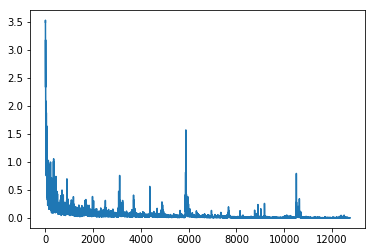

12746

In [8]:
import pylab
pylab.figure()
pylab.plot(costs)
pylab.show()
step

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records/checkpoint-12746


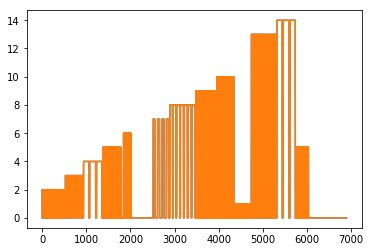

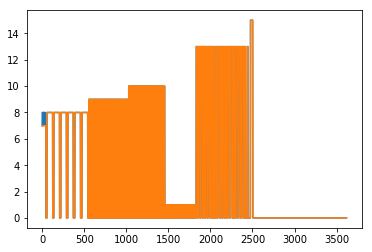

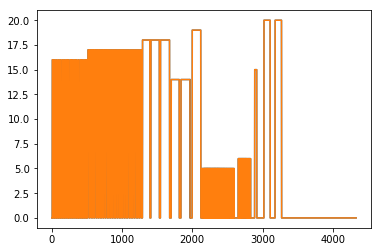

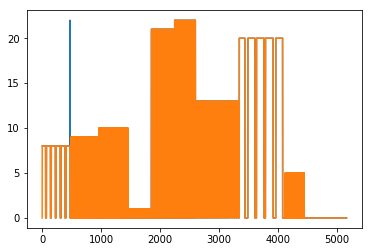

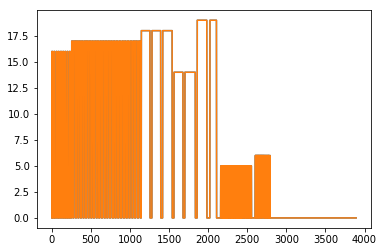

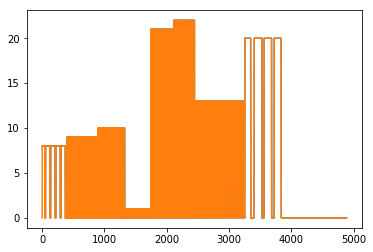

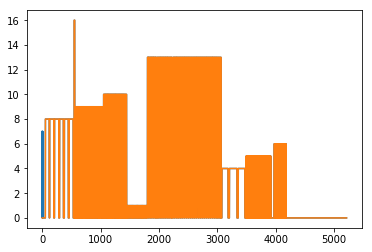

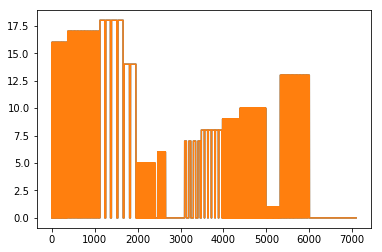

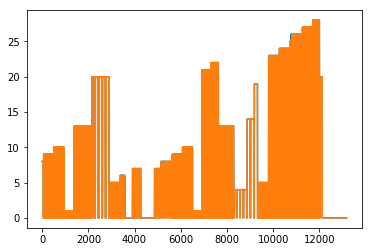

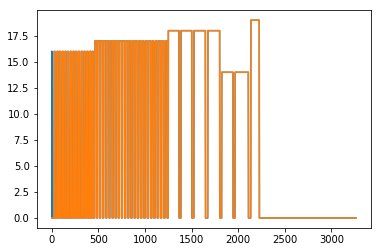

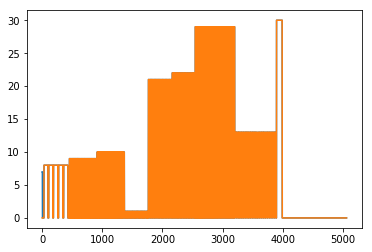

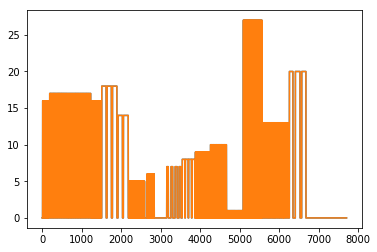

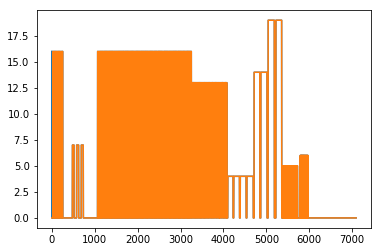

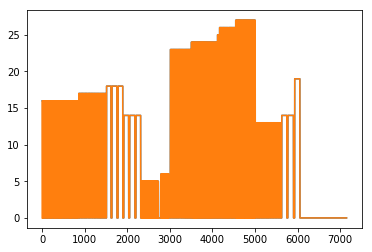

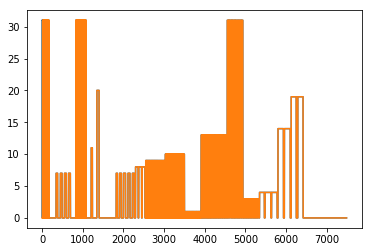

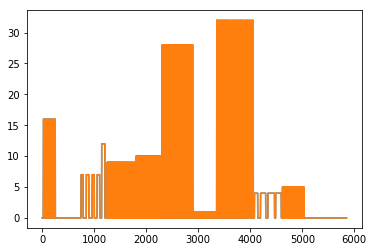

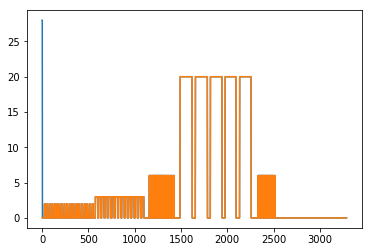

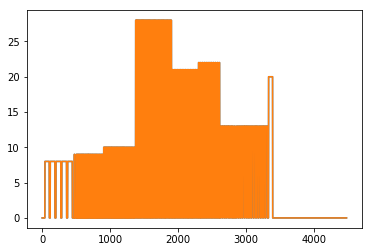

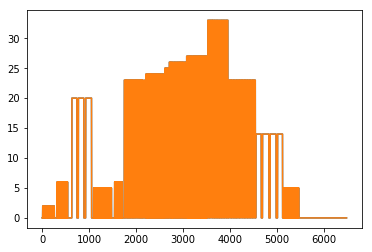

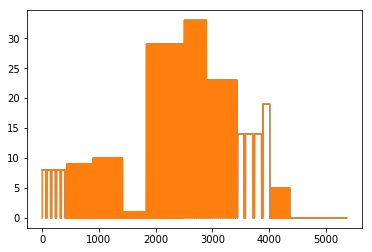

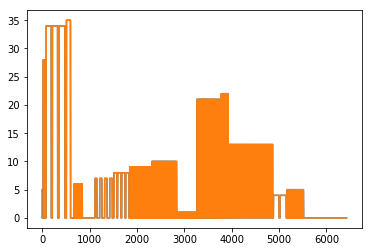

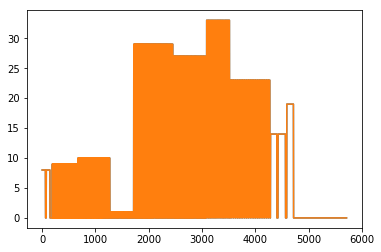

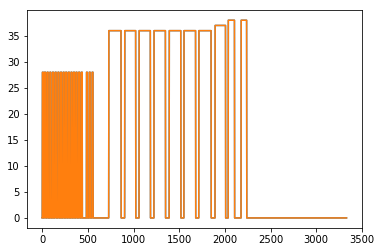

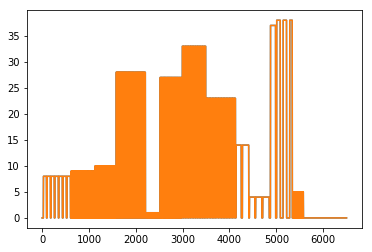

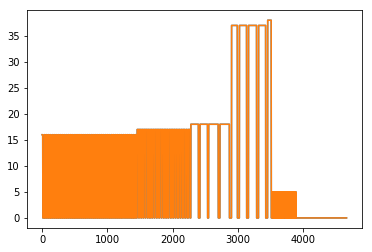

In [9]:
import pylab
# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-12746.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-12746"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        temp_n = len(intY)/batch_size
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
        d = {X: data1,Y:intY, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        errors.append(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)
        pylab.figure()
        pylab.plot(np.squeeze(pred[1]).reshape(-1))
        pylab.plot(intY.reshape(-1))
        pylab.show()

In [10]:
# Results on training set
([np.mean(err) for err in errors])

[0.00043497172683775554,
 0.0099474993092014373,
 0.0016151361329026304,
 0.00058150804419461141,
 0.0,
 0.0012285012285012285,
 0.0021097046413502108,
 0.00084566596194503166,
 0.00098649263924723029,
 0.0015304560759106215,
 0.0011857707509881424,
 0.00012968486577616392,
 0.001127554615926709,
 0.0011188811188811189,
 0.00066746762782005076,
 0.00017088174982911826,
 0.00091213134691395562,
 0.00044672771945499217,
 0.0004630344188918043,
 0.00018628912071535022,
 0.00077833125778331254,
 0.00035032404974601509,
 0.00030003000300030005,
 0.00015382248884786957,
 0.0002144082332761578]

11

In [32]:
test_data_directory = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/mat/test_data'
import glob
os.chdir(test_data_directory)
file_list = glob.glob('*.mat')

# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-12746.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-12746"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)

    # Run evaluation.
    # load current training file
    keys = np.zeros((len(file_list),), dtype=np.object)
    estimates = np.zeros((len(file_list),), dtype=np.object)
    file_num = 0
    for fname in file_list:
    #fname = file_list[file_num]
        print fname
        keys[file_num] = fname    
        data = cpio.loadmat(test_data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        print data1.shape
        temp_n = data1.shape[0]/batch_size
        rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        print data1.shape
        temp_n = temp_n + 1
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        print data1.shape
        d = {X: data1, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        estim = np.squeeze(pred[1]).reshape(-1)
        estimates[file_num] = estim
        file_num = file_num + 1

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records/checkpoint-12746
lrb85315_1000_2017_03_24_07_01_21.mat
(6899, 513)
(6908, 513)
(11, 628, 513)
lrb85315_1001_2017_03_24_07_01_49.mat
(3623, 513)
(3630, 513)
(11, 330, 513)
lrb85315_1002_2017_03_24_07_02_17.mat
(4344, 513)
(4345, 513)
(11, 395, 513)
lrb85315_1003_2017_03_24_07_02_31.mat
(5159, 513)
(5170, 513)
(11, 470, 513)
lrb85315_1004_2017_03_24_07_02_59.mat
(3902, 513)
(3905, 513)
(11, 355, 513)
lrb85315_1005_2017_03_24_07_03_11.mat
(4891, 513)
(4895, 513)
(11, 445, 513)
lrb85315_1006_2017_03_24_07_03_34.mat
(5223, 513)
(5225, 513)
(11, 475, 513)
lrb85315_1007_2017_03_24_07_04_00.mat
(7104, 513)
(7106, 513)
(11, 646, 513)
lrb85315_1008_2017_03_24_07_04_40.mat
(13187, 513)
(13189, 513)
(11, 1199, 513)
lrb85315_1009_2017_03_24_07_08_35.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_100_2017_03_08_14_24_01.mat
(1724, 513)
(1727, 513)
(11, 157, 513)
lrb85315_

lrb85315_1096_2017_03_27_06_46_11.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1097_2017_03_27_06_46_21.mat
(1241, 513)
(1243, 513)
(11, 113, 513)
lrb85315_1098_2017_03_27_06_46_25.mat
(2091, 513)
(2101, 513)
(11, 191, 513)
lrb85315_1099_2017_03_27_06_46_44.mat
(5335, 513)
(5346, 513)
(11, 486, 513)
lrb85315_109_2017_03_08_14_25_51.mat
(604, 513)
(605, 513)
(11, 55, 513)
lrb85315_10_2017_03_03_10_37_48.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1100_2017_03_27_06_47_09.mat
(4572, 513)
(4576, 513)
(11, 416, 513)
lrb85315_1101_2017_03_27_06_47_38.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1102_2017_03_27_06_47_42.mat
(5032, 513)
(5038, 513)
(11, 458, 513)
lrb85315_1103_2017_03_27_06_47_59.mat
(4924, 513)
(4928, 513)
(11, 448, 513)
lrb85315_1104_2017_03_27_06_48_34.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1105_2017_03_27_06_48_45.mat
(5367, 513)
(5368, 513)
(11, 488, 513)
lrb85315_1106_2017_03_27_06_49_00.mat
(6418, 513)
(6424, 513)
(11, 584, 513)
lrb85

lrb85315_1192_2017_03_27_08_18_21.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1193_2017_03_27_08_18_30.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1194_2017_03_27_08_20_59.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1195_2017_03_27_08_21_14.mat
(1688, 513)
(1694, 513)
(11, 154, 513)
lrb85315_1196_2017_03_27_08_24_37.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lrb85315_1197_2017_03_27_08_24_44.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1198_2017_03_27_08_24_53.mat
(2600, 513)
(2607, 513)
(11, 237, 513)
lrb85315_1199_2017_03_27_08_25_07.mat
(5606, 513)
(5610, 513)
(11, 510, 513)
lrb85315_119_2017_03_08_14_27_11.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_11_2017_03_03_16_36_33.mat
(1042, 513)
(1045, 513)
(11, 95, 513)
lrb85315_1200_2017_03_27_08_25_48.mat
(1482, 513)
(1485, 513)
(11, 135, 513)
lrb85315_1201_2017_03_27_08_26_08.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1202_2017_03_27_08_27_39.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb

lrb85315_128_2017_03_08_14_28_19.mat
(1965, 513)
(1969, 513)
(11, 179, 513)
lrb85315_1290_2017_03_29_07_07_53.mat
(7657, 513)
(7667, 513)
(11, 697, 513)
lrb85315_1291_2017_03_29_07_08_20.mat
(4662, 513)
(4664, 513)
(11, 424, 513)
lrb85315_1292_2017_03_29_07_08_44.mat
(5540, 513)
(5544, 513)
(11, 504, 513)
lrb85315_1293_2017_03_29_07_09_06.mat
(3795, 513)
(3806, 513)
(11, 346, 513)
lrb85315_1294_2017_03_29_07_11_59.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1295_2017_03_29_07_13_45.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1296_2017_03_29_07_14_09.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_1297_2017_03_29_07_14_18.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1298_2017_03_29_07_16_43.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1299_2017_03_29_07_18_03.mat
(4177, 513)
(4180, 513)
(11, 380, 513)
lrb85315_129_2017_03_08_14_28_27.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_12_2017_03_06_09_54_50.mat
(690, 513)
(693, 513)
(11, 63, 513)
lrb853

lrb85315_1386_2017_03_29_09_20_08.mat
(1278, 513)
(1287, 513)
(11, 117, 513)
lrb85315_1387_2017_03_29_09_20_12.mat
(4621, 513)
(4631, 513)
(11, 421, 513)
lrb85315_1388_2017_03_29_09_20_45.mat
(1428, 513)
(1430, 513)
(11, 130, 513)
lrb85315_1389_2017_03_29_09_20_51.mat
(7766, 513)
(7777, 513)
(11, 707, 513)
lrb85315_138_2017_03_08_14_31_39.mat
(397, 513)
(407, 513)
(11, 37, 513)
lrb85315_1390_2017_03_29_09_21_26.mat
(7175, 513)
(7183, 513)
(11, 653, 513)
lrb85315_1391_2017_03_29_09_22_08.mat
(1764, 513)
(1771, 513)
(11, 161, 513)
lrb85315_1392_2017_03_29_09_22_15.mat
(10387, 513)
(10395, 513)
(11, 945, 513)
lrb85315_1393_2017_03_30_06_07_35.mat
(593, 513)
(594, 513)
(11, 54, 513)
lrb85315_1394_2017_03_30_06_29_30.mat
(591, 513)
(594, 513)
(11, 54, 513)
lrb85315_1395_2017_03_30_06_29_56.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_1396_2017_03_30_06_30_31.mat
(574, 513)
(583, 513)
(11, 53, 513)
lrb85315_1397_2017_03_30_06_31_10.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_1398_20

(6734, 513)
(6743, 513)
(11, 613, 513)
lrb85315_1484_2017_04_01_06_47_58.mat
(4724, 513)
(4730, 513)
(11, 430, 513)
lrb85315_1485_2017_04_01_06_48_38.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1486_2017_04_01_06_48_53.mat
(4648, 513)
(4653, 513)
(11, 423, 513)
lrb85315_1487_2017_04_01_06_49_13.mat
(5656, 513)
(5665, 513)
(11, 515, 513)
lrb85315_1488_2017_04_01_06_49_54.mat
(4820, 513)
(4829, 513)
(11, 439, 513)
lrb85315_1489_2017_04_01_06_50_14.mat
(5047, 513)
(5049, 513)
(11, 459, 513)
lrb85315_148_2017_03_09_09_42_27.mat
(2548, 513)
(2552, 513)
(11, 232, 513)
lrb85315_1490_2017_04_01_06_50_37.mat
(3876, 513)
(3883, 513)
(11, 353, 513)
lrb85315_1491_2017_04_01_06_50_53.mat
(5175, 513)
(5181, 513)
(11, 471, 513)
lrb85315_1492_2017_04_01_06_51_18.mat
(4365, 513)
(4367, 513)
(11, 397, 513)
lrb85315_1493_2017_04_01_06_52_13.mat
(6012, 513)
(6017, 513)
(11, 547, 513)
lrb85315_1494_2017_04_01_06_52_41.mat
(5202, 513)
(5203, 513)
(11, 473, 513)
lrb85315_1495_2017_04_01_06_57_55.mat


lrb85315_157_2017_03_09_09_49_35.mat
(7172, 513)
(7183, 513)
(11, 653, 513)
lrb85315_1580_2017_04_01_07_55_52.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1581_2017_04_01_07_56_23.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1582_2017_04_01_07_58_02.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1583_2017_04_01_07_58_38.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1584_2017_04_01_08_00_24.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1585_2017_04_01_08_01_35.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1586_2017_04_01_08_03_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1587_2017_04_01_08_03_20.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1588_2017_04_01_08_04_08.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1589_2017_04_01_08_04_12.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lrb85315_1590_2017_04_01_08_05_08.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1591_2017_04_01_08_05_12.mat
(1101, 513)
(1111, 513)
(11, 101, 513)


lrb85315_1678_2017_04_01_09_35_44.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1679_2017_04_01_09_36_04.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_167_2017_03_09_13_20_50.mat
(1162, 513)
(1166, 513)
(11, 106, 513)
lrb85315_1680_2017_04_01_09_42_02.mat
(1815, 513)
(1826, 513)
(11, 166, 513)
lrb85315_1681_2017_04_01_09_44_45.mat
(1114, 513)
(1122, 513)
(11, 102, 513)
lrb85315_1682_2017_04_01_09_46_08.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1683_2017_04_01_09_46_28.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1684_2017_04_01_09_51_13.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1685_2017_04_01_09_51_39.mat
(2610, 513)
(2618, 513)
(11, 238, 513)
lrb85315_1686_2017_04_01_09_51_46.mat
(1793, 513)
(1804, 513)
(11, 164, 513)
lrb85315_1687_2017_04_01_09_52_10.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lrb85315_1688_2017_04_01_09_53_23.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1689_2017_04_01_09_54_06.mat
(1108, 513)
(1111, 513)
(11, 101, 513)


lrb85315_1774_2017_04_03_08_02_50.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1775_2017_04_03_08_03_07.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1776_2017_04_03_08_03_46.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1777_2017_04_03_08_05_21.mat
(1082, 513)
(1089, 513)
(11, 99, 513)
lrb85315_1778_2017_04_03_08_09_00.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1779_2017_04_03_08_09_27.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_177_2017_03_10_09_01_43.mat
(1198, 513)
(1199, 513)
(11, 109, 513)
lrb85315_1780_2017_04_03_08_13_35.mat
(3635, 513)
(3641, 513)
(11, 331, 513)
lrb85315_1781_2017_04_03_08_15_07.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lrb85315_1782_2017_04_03_08_17_20.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_1783_2017_04_03_08_17_35.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1784_2017_04_03_08_17_50.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1785_2017_04_03_08_18_08.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lr

lrb85315_1871_2017_04_06_06_29_41.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1872_2017_04_06_06_30_16.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1873_2017_04_06_06_33_32.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1874_2017_04_06_06_34_15.mat
(3096, 513)
(3102, 513)
(11, 282, 513)
lrb85315_1875_2017_04_06_06_34_27.mat
(6663, 513)
(6666, 513)
(11, 606, 513)
lrb85315_1876_2017_04_06_06_34_55.mat
(8286, 513)
(8294, 513)
(11, 754, 513)
lrb85315_1877_2017_04_06_06_35_35.mat
(8719, 513)
(8723, 513)
(11, 793, 513)
lrb85315_1878_2017_04_06_06_37_40.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1879_2017_04_06_06_38_10.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_187_2017_03_11_09_48_57.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lrb85315_1880_2017_04_06_06_41_38.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1881_2017_04_06_06_49_10.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1882_2017_04_06_06_50_32.mat
(1595, 513)
(1606, 513)
(11, 146, 513)


lrb85315_1968_2017_04_06_08_58_09.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1969_2017_04_06_08_58_57.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_196_2017_03_11_09_50_00.mat
(1257, 513)
(1265, 513)
(11, 115, 513)
lrb85315_1970_2017_04_06_08_59_19.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1971_2017_04_06_09_00_53.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1972_2017_04_06_09_01_01.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1973_2017_04_06_09_01_23.mat
(1915, 513)
(1925, 513)
(11, 175, 513)
lrb85315_1974_2017_04_06_09_02_31.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1975_2017_04_06_09_03_15.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1976_2017_04_06_09_05_06.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1977_2017_04_06_09_07_02.mat
(2265, 513)
(2266, 513)
(11, 206, 513)
lrb85315_1978_2017_04_06_09_07_14.mat
(3579, 513)
(3586, 513)
(11, 326, 513)
lrb85315_1979_2017_04_06_09_07_25.mat
(6550, 513)
(6556, 513)
(11, 596, 513)


lrb85315_2064_2017_04_07_07_42_24.mat
(9213, 513)
(9218, 513)
(11, 838, 513)
lrb85315_2065_2017_04_07_07_42_50.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2066_2017_04_07_07_43_02.mat
(4682, 513)
(4686, 513)
(11, 426, 513)
lrb85315_2067_2017_04_07_07_43_26.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2068_2017_04_07_07_43_45.mat
(3113, 513)
(3124, 513)
(11, 284, 513)
lrb85315_2069_2017_04_07_07_44_01.mat
(4027, 513)
(4037, 513)
(11, 367, 513)
lrb85315_206_2017_03_11_09_51_31.mat
(6199, 513)
(6204, 513)
(11, 564, 513)
lrb85315_2070_2017_04_07_07_44_48.mat
(2945, 513)
(2948, 513)
(11, 268, 513)
lrb85315_2071_2017_04_07_07_45_16.mat
(4919, 513)
(4928, 513)
(11, 448, 513)
lrb85315_2072_2017_04_07_07_46_35.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2073_2017_04_07_07_47_56.mat
(1802, 513)
(1804, 513)
(11, 164, 513)
lrb85315_2074_2017_04_07_07_48_03.mat
(1541, 513)
(1551, 513)
(11, 141, 513)
lrb85315_2075_2017_04_07_07_49_25.mat
(1122, 513)
(1133, 513)
(11, 103, 513)


lrb85315_2160_2017_04_10_07_00_38.mat
(3980, 513)
(3982, 513)
(11, 362, 513)
lrb85315_2161_2017_04_10_07_01_14.mat
(8408, 513)
(8415, 513)
(11, 765, 513)
lrb85315_2162_2017_04_10_07_03_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2163_2017_04_10_07_03_14.mat
(5523, 513)
(5533, 513)
(11, 503, 513)
lrb85315_2164_2017_04_10_07_03_40.mat
(5256, 513)
(5258, 513)
(11, 478, 513)
lrb85315_2165_2017_04_10_07_03_56.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2166_2017_04_10_07_10_40.mat
(1380, 513)
(1386, 513)
(11, 126, 513)
lrb85315_2167_2017_04_10_07_10_47.mat
(7605, 513)
(7612, 513)
(11, 692, 513)
lrb85315_2168_2017_04_10_07_11_41.mat
(7030, 513)
(7040, 513)
(11, 640, 513)
lrb85315_2169_2017_04_10_07_20_36.mat
(6806, 513)
(6809, 513)
(11, 619, 513)
lrb85315_216_2017_03_11_10_08_52.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lrb85315_2170_2017_04_10_07_26_32.mat
(4411, 513)
(4422, 513)
(11, 402, 513)
lrb85315_2171_2017_04_10_07_26_57.mat
(1124, 513)
(1133, 513)
(11, 103, 513)


lrb85315_2257_2017_04_16_06_32_33.mat
(2029, 513)
(2035, 513)
(11, 185, 513)
lrb85315_2258_2017_04_16_06_37_05.mat
(2167, 513)
(2178, 513)
(11, 198, 513)
lrb85315_2259_2017_04_16_06_37_16.mat
(6839, 513)
(6842, 513)
(11, 622, 513)
lrb85315_225_2017_03_11_13_42_41.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2260_2017_04_16_06_41_43.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2261_2017_04_16_06_44_44.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2262_2017_04_16_06_46_52.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2263_2017_04_16_06_48_02.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2264_2017_04_16_06_50_01.mat
(1084, 513)
(1089, 513)
(11, 99, 513)
lrb85315_2265_2017_04_16_06_50_37.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2266_2017_04_16_06_50_42.mat
(1087, 513)
(1089, 513)
(11, 99, 513)
lrb85315_2267_2017_04_16_06_54_13.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2268_2017_04_16_06_54_47.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lr

lrb85315_2353_2017_04_16_08_05_52.mat
(3420, 513)
(3421, 513)
(11, 311, 513)
lrb85315_2354_2017_04_16_08_07_26.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2355_2017_04_16_08_08_01.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2356_2017_04_16_08_09_02.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2357_2017_04_16_08_09_22.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2358_2017_04_16_08_11_20.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2359_2017_04_16_08_12_35.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_235_2017_03_11_15_43_18.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lrb85315_2360_2017_04_16_08_12_55.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2361_2017_04_16_08_16_48.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2362_2017_04_16_08_17_26.mat
(7992, 513)
(7997, 513)
(11, 727, 513)
lrb85315_2363_2017_04_16_08_18_18.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2364_2017_04_16_08_19_18.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
l

lrb85315_244_2017_03_11_17_02_44.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2450_2017_04_18_06_15_00.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2451_2017_04_18_06_15_04.mat
(1073, 513)
(1078, 513)
(11, 98, 513)
lrb85315_2452_2017_04_18_06_15_07.mat
(4994, 513)
(5005, 513)
(11, 455, 513)
lrb85315_2453_2017_04_18_06_15_28.mat
(3540, 513)
(3542, 513)
(11, 322, 513)
lrb85315_2454_2017_04_18_06_15_38.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2455_2017_04_18_06_15_42.mat
(3958, 513)
(3960, 513)
(11, 360, 513)
lrb85315_2456_2017_04_18_06_16_02.mat
(4251, 513)
(4257, 513)
(11, 387, 513)
lrb85315_2457_2017_04_18_06_16_24.mat
(5623, 513)
(5632, 513)
(11, 512, 513)
lrb85315_2458_2017_04_18_06_17_00.mat
(5574, 513)
(5577, 513)
(11, 507, 513)
lrb85315_2459_2017_04_18_06_21_49.mat
(1749, 513)
(1760, 513)
(11, 160, 513)
lrb85315_245_2017_03_11_17_05_54.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2460_2017_04_18_06_22_01.mat
(4366, 513)
(4367, 513)
(11, 397, 513)
lr

lrb85315_2546_2017_04_18_08_32_55.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2547_2017_04_18_08_34_34.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2548_2017_04_18_08_39_39.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2549_2017_04_18_08_39_46.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_254_2017_03_11_20_38_43.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2550_2017_04_18_08_39_50.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2551_2017_04_18_08_40_10.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2552_2017_04_18_08_40_48.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_2553_2017_04_18_08_46_09.mat
(2083, 513)
(2090, 513)
(11, 190, 513)
lrb85315_2554_2017_04_18_08_47_22.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2555_2017_04_18_08_49_42.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2556_2017_04_18_08_49_51.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2557_2017_04_18_08_49_55.mat
(3200, 513)
(3201, 513)
(11, 291, 513)


(15602, 513)
(15609, 513)
(11, 1419, 513)
lrb85315_2665_2017_04_19_07_18_46.mat
(25714, 513)
(25718, 513)
(11, 2338, 513)
lrb85315_2666_2017_04_19_07_19_31.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2668_2017_04_19_07_19_57.mat
(7479, 513)
(7480, 513)
(11, 680, 513)
lrb85315_2669_2017_04_19_07_22_27.mat
(4145, 513)
(4147, 513)
(11, 377, 513)
lrb85315_266_2017_03_12_07_25_17.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2670_2017_04_19_07_22_48.mat
(30866, 513)
(30877, 513)
(11, 2807, 513)
lrb85315_2671_2017_04_19_07_23_23.mat
(3330, 513)
(3333, 513)
(11, 303, 513)
lrb85315_2672_2017_04_19_07_23_32.mat
(6099, 513)
(6105, 513)
(11, 555, 513)
lrb85315_2673_2017_04_19_07_23_59.mat
(9746, 513)
(9757, 513)
(11, 887, 513)
lrb85315_2674_2017_04_19_07_24_13.mat
(25685, 513)
(25696, 513)
(11, 2336, 513)
lrb85315_2675_2017_04_19_07_24_37.mat
(5381, 513)
(5390, 513)
(11, 490, 513)
lrb85315_2677_2017_04_19_07_25_25.mat
(6349, 513)
(6358, 513)
(11, 578, 513)
lrb85315_2678_2017_04_19_0

lrb85315_2777_2017_04_20_06_10_42.mat
(7366, 513)
(7370, 513)
(11, 670, 513)
lrb85315_2778_2017_04_20_06_11_27.mat
(1873, 513)
(1881, 513)
(11, 171, 513)
lrb85315_2779_2017_04_20_06_11_45.mat
(4858, 513)
(4862, 513)
(11, 442, 513)
lrb85315_277_2017_03_12_08_29_45.mat
(2339, 513)
(2343, 513)
(11, 213, 513)
lrb85315_2780_2017_04_20_06_12_12.mat
(3817, 513)
(3828, 513)
(11, 348, 513)
lrb85315_2781_2017_04_20_06_12_36.mat
(7430, 513)
(7436, 513)
(11, 676, 513)
lrb85315_2782_2017_04_20_06_15_35.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2783_2017_04_20_06_16_20.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2784_2017_04_20_06_20_44.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2785_2017_04_20_06_22_51.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2786_2017_04_20_06_24_35.mat
(3318, 513)
(3322, 513)
(11, 302, 513)
lrb85315_2787_2017_04_20_06_24_46.mat
(5238, 513)
(5247, 513)
(11, 477, 513)
lrb85315_2788_2017_04_20_06_25_03.mat
(1098, 513)
(1100, 513)
(11, 100, 513)


lrb85315_2873_2017_04_20_07_33_55.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2874_2017_04_20_07_36_47.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2875_2017_04_20_07_37_21.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2876_2017_04_20_07_37_55.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2877_2017_04_20_07_39_37.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2878_2017_04_20_07_40_57.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_2879_2017_04_20_07_41_06.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_287_2017_03_12_10_29_14.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2880_2017_04_20_07_41_13.mat
(6815, 513)
(6820, 513)
(11, 620, 513)
lrb85315_2881_2017_04_20_07_41_35.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2882_2017_04_20_07_43_01.mat
(1352, 513)
(1353, 513)
(11, 123, 513)
lrb85315_2883_2017_04_20_07_43_08.mat
(1872, 513)
(1881, 513)
(11, 171, 513)
lrb85315_2884_2017_04_20_07_43_25.mat
(3508, 513)
(3509, 513)
(11, 319, 513)


lrb85315_296_2017_03_12_12_18_02.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2970_2017_04_21_06_09_34.mat
(1348, 513)
(1353, 513)
(11, 123, 513)
lrb85315_2971_2017_04_21_06_09_40.mat
(5369, 513)
(5379, 513)
(11, 489, 513)
lrb85315_2972_2017_04_21_06_10_04.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2973_2017_04_21_06_10_08.mat
(4669, 513)
(4675, 513)
(11, 425, 513)
lrb85315_2974_2017_04_21_06_10_30.mat
(6163, 513)
(6171, 513)
(11, 561, 513)
lrb85315_2975_2017_04_21_06_11_06.mat
(1620, 513)
(1628, 513)
(11, 148, 513)
lrb85315_2976_2017_04_21_06_11_16.mat
(7011, 513)
(7018, 513)
(11, 638, 513)
lrb85315_2977_2017_04_21_06_14_09.mat
(2758, 513)
(2761, 513)
(11, 251, 513)
lrb85315_2978_2017_04_21_06_14_21.mat
(4516, 513)
(4521, 513)
(11, 411, 513)
lrb85315_2979_2017_04_21_06_14_35.mat
(1152, 513)
(1155, 513)
(11, 105, 513)
lrb85315_297_2017_03_12_12_25_24.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2980_2017_04_21_06_14_50.mat
(5310, 513)
(5313, 513)
(11, 483, 513)
l

lrb85315_3065_2017_04_21_08_29_30.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3066_2017_04_21_08_29_52.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3067_2017_04_21_08_29_55.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3068_2017_04_21_08_30_02.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_3069_2017_04_21_08_30_13.mat
(3052, 513)
(3058, 513)
(11, 278, 513)
lrb85315_306_2017_03_12_16_38_07.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3070_2017_04_21_08_30_24.mat
(8439, 513)
(8448, 513)
(11, 768, 513)
lrb85315_3071_2017_04_21_08_30_53.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3072_2017_04_21_08_30_58.mat
(25, 513)
(33, 513)
(11, 3, 513)
lrb85315_3073_2017_04_21_08_31_25.mat
(5895, 513)
(5896, 513)
(11, 536, 513)
lrb85315_3074_2017_04_21_08_32_08.mat
(5969, 513)
(5973, 513)
(11, 543, 513)
lrb85315_3075_2017_04_21_08_32_35.mat
(8314, 513)
(8316, 513)
(11, 756, 513)
lrb85315_3076_2017_04_21_08_33_04.mat
(6838, 513)
(6842, 513)
(11, 622, 513)
lrb853

lrb85315_3161_2017_04_23_05_59_26.mat
(8333, 513)
(8338, 513)
(11, 758, 513)
lrb85315_3162_2017_04_23_06_00_17.mat
(2947, 513)
(2948, 513)
(11, 268, 513)
lrb85315_3163_2017_04_23_06_00_27.mat
(6026, 513)
(6028, 513)
(11, 548, 513)
lrb85315_3164_2017_04_23_06_01_48.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3165_2017_04_23_06_02_55.mat
(4029, 513)
(4037, 513)
(11, 367, 513)
lrb85315_3166_2017_04_23_06_03_08.mat
(3376, 513)
(3377, 513)
(11, 307, 513)
lrb85315_3167_2017_04_23_06_03_27.mat
(5052, 513)
(5060, 513)
(11, 460, 513)
lrb85315_3168_2017_04_23_06_03_53.mat
(4341, 513)
(4345, 513)
(11, 395, 513)
lrb85315_3169_2017_04_23_06_04_09.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_316_2017_03_12_18_43_22.mat
(1283, 513)
(1287, 513)
(11, 117, 513)
lrb85315_3170_2017_04_23_06_05_11.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3171_2017_04_23_06_05_54.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3172_2017_04_23_06_06_12.mat
(1131, 513)
(1133, 513)
(11, 103, 513)


(5940, 513)
(11, 540, 513)
lrb85315_3258_2017_04_23_06_33_37.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3259_2017_04_23_06_34_03.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_325_2017_03_12_20_26_48.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3260_2017_04_23_06_34_11.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3261_2017_04_23_06_34_28.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3262_2017_04_23_06_34_39.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3263_2017_04_23_06_34_57.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3264_2017_04_23_06_35_10.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3265_2017_04_23_06_35_14.mat
(2095, 513)
(2101, 513)
(11, 191, 513)
lrb85315_3266_2017_04_23_06_35_49.mat
(1822, 513)
(1826, 513)
(11, 166, 513)
lrb85315_3267_2017_04_23_06_35_55.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_3268_2017_04_23_06_36_01.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3269_2017_04_23_06_36_58.mat
(1124, 513)


lrb85315_3354_2017_04_23_07_05_14.mat
(2110, 513)
(2112, 513)
(11, 192, 513)
lrb85315_3355_2017_04_23_07_05_24.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3356_2017_04_23_07_05_30.mat
(2386, 513)
(2387, 513)
(11, 217, 513)
lrb85315_3357_2017_04_23_07_06_09.mat
(2067, 513)
(2068, 513)
(11, 188, 513)
lrb85315_3358_2017_04_23_07_06_31.mat
(5273, 513)
(5280, 513)
(11, 480, 513)
lrb85315_3359_2017_04_23_07_06_49.mat
(6634, 513)
(6644, 513)
(11, 604, 513)
lrb85315_335_2017_03_13_07_33_00.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3360_2017_04_23_07_07_09.mat
(2741, 513)
(2750, 513)
(11, 250, 513)
lrb85315_3361_2017_04_23_07_07_16.mat
(6148, 513)
(6149, 513)
(11, 559, 513)
lrb85315_3362_2017_04_23_07_07_46.mat
(5495, 513)
(5500, 513)
(11, 500, 513)
lrb85315_3363_2017_04_23_07_08_06.mat
(5103, 513)
(5104, 513)
(11, 464, 513)
lrb85315_3364_2017_04_23_07_08_21.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3365_2017_04_23_07_08_34.mat
(7918, 513)
(7920, 513)
(11, 720, 513)


lrb85315_3450_2017_04_23_07_49_01.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3451_2017_04_23_07_49_22.mat
(2435, 513)
(2442, 513)
(11, 222, 513)
lrb85315_3452_2017_04_23_07_49_51.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3453_2017_04_23_07_50_06.mat
(1208, 513)
(1210, 513)
(11, 110, 513)
lrb85315_3454_2017_04_23_07_50_10.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3455_2017_04_23_07_50_14.mat
(1689, 513)
(1694, 513)
(11, 154, 513)
lrb85315_3456_2017_04_23_07_50_26.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3457_2017_04_23_07_50_33.mat
(1739, 513)
(1749, 513)
(11, 159, 513)
lrb85315_3458_2017_04_23_07_50_38.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3459_2017_04_23_07_51_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_345_2017_03_13_07_36_28.mat
(1942, 513)
(1947, 513)
(11, 177, 513)
lrb85315_3460_2017_04_23_07_51_21.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3461_2017_04_23_07_51_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)


lrb85315_3547_2017_04_23_08_19_38.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3548_2017_04_23_08_20_45.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3549_2017_04_23_08_20_54.mat
(2350, 513)
(2354, 513)
(11, 214, 513)
lrb85315_354_2017_03_13_08_00_21.mat
(1526, 513)
(1529, 513)
(11, 139, 513)
lrb85315_3550_2017_04_23_08_21_01.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3551_2017_04_23_08_21_27.mat
(2698, 513)
(2706, 513)
(11, 246, 513)
lrb85315_3552_2017_04_23_08_21_49.mat
(1915, 513)
(1925, 513)
(11, 175, 513)
lrb85315_3553_2017_04_23_08_22_00.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3554_2017_04_23_08_23_51.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3555_2017_04_23_08_24_25.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3556_2017_04_23_08_24_43.mat
(2388, 513)
(2398, 513)
(11, 218, 513)
lrb85315_3557_2017_04_23_08_24_58.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3558_2017_04_23_08_25_03.mat
(1133, 513)
(1144, 513)
(11, 104, 513)


lrb85315_3643_2017_04_23_09_01_18.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3644_2017_04_23_09_01_22.mat
(1113, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3645_2017_04_23_09_01_37.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3646_2017_04_23_09_02_08.mat
(2258, 513)
(2266, 513)
(11, 206, 513)
lrb85315_3647_2017_04_23_09_02_15.mat
(3114, 513)
(3124, 513)
(11, 284, 513)
lrb85315_3648_2017_04_23_09_02_36.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lrb85315_3649_2017_04_23_09_03_11.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_364_2017_03_13_09_36_43.mat
(3217, 513)
(3223, 513)
(11, 293, 513)
lrb85315_3650_2017_04_23_09_03_17.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3651_2017_04_23_09_03_20.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3652_2017_04_23_09_03_28.mat
(1345, 513)
(1353, 513)
(11, 123, 513)
lrb85315_3653_2017_04_23_09_03_43.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3654_2017_04_23_09_03_52.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_3740_2017_04_24_02_38_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3741_2017_04_24_02_38_15.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3742_2017_04_24_02_39_12.mat
(1715, 513)
(1716, 513)
(11, 156, 513)
lrb85315_3743_2017_04_24_02_39_42.mat
(2185, 513)
(2189, 513)
(11, 199, 513)
lrb85315_3744_2017_04_24_02_40_59.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3745_2017_04_24_02_41_42.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3746_2017_04_24_02_43_01.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3747_2017_04_24_02_43_22.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3748_2017_04_24_02_44_10.mat
(1604, 513)
(1606, 513)
(11, 146, 513)
lrb85315_3749_2017_04_24_02_45_26.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lrb85315_374_2017_03_16_09_48_11.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3750_2017_04_24_02_45_50.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3751_2017_04_24_02_46_18.mat
(1105, 513)
(1111, 513)
(11, 101, 513)


lrb85315_3837_2017_04_24_06_10_18.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3838_2017_04_24_06_10_29.mat
(1738, 513)
(1749, 513)
(11, 159, 513)
lrb85315_3839_2017_04_24_06_10_37.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_383_2017_03_16_10_01_46.mat
(4091, 513)
(4092, 513)
(11, 372, 513)
lrb85315_3840_2017_04_24_06_10_48.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3841_2017_04_24_06_10_52.mat
(2213, 513)
(2222, 513)
(11, 202, 513)
lrb85315_3842_2017_04_24_06_10_58.mat
(3208, 513)
(3212, 513)
(11, 292, 513)
lrb85315_3843_2017_04_24_06_11_11.mat
(5668, 513)
(5676, 513)
(11, 516, 513)
lrb85315_3844_2017_04_24_06_11_37.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3845_2017_04_24_06_11_46.mat
(4947, 513)
(4950, 513)
(11, 450, 513)
lrb85315_3846_2017_04_24_06_12_06.mat
(7733, 513)
(7744, 513)
(11, 704, 513)
lrb85315_3847_2017_04_24_06_12_29.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3848_2017_04_24_06_12_33.mat
(1102, 513)
(1111, 513)
(11, 101, 513)


lrb85315_3933_2017_04_24_06_35_11.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3934_2017_04_24_06_35_20.mat
(2227, 513)
(2233, 513)
(11, 203, 513)
lrb85315_3935_2017_04_24_06_35_28.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3936_2017_04_24_06_35_31.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3937_2017_04_24_06_35_47.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3938_2017_04_24_06_38_16.mat
(1074, 513)
(1078, 513)
(11, 98, 513)
lrb85315_3939_2017_04_24_06_39_09.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_393_2017_03_16_10_47_58.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3940_2017_04_24_06_39_17.mat
(1201, 513)
(1210, 513)
(11, 110, 513)
lrb85315_3941_2017_04_24_06_39_29.mat
(1141, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3942_2017_04_24_06_40_46.mat
(2225, 513)
(2233, 513)
(11, 203, 513)
lrb85315_3943_2017_04_24_06_41_06.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3944_2017_04_24_06_41_44.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
l

lrb85315_4029_2017_04_24_07_12_51.mat
(1736, 513)
(1738, 513)
(11, 158, 513)
lrb85315_402_2017_03_16_11_37_58.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4030_2017_04_24_07_12_57.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lrb85315_4031_2017_04_24_07_13_04.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4032_2017_04_24_07_13_12.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4033_2017_04_24_07_13_35.mat
(1406, 513)
(1408, 513)
(11, 128, 513)
lrb85315_4034_2017_04_24_07_13_44.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lrb85315_4035_2017_04_24_07_14_45.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4036_2017_04_24_07_15_26.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4037_2017_04_24_07_15_32.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4038_2017_04_24_07_16_43.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4039_2017_04_24_07_16_50.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_403_2017_03_16_11_38_13.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_4125_2017_04_24_07_44_48.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4126_2017_04_24_07_45_32.mat
(1320, 513)
(1331, 513)
(11, 121, 513)
lrb85315_4127_2017_04_24_07_45_50.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4128_2017_04_24_07_46_39.mat
(2082, 513)
(2090, 513)
(11, 190, 513)
lrb85315_4129_2017_04_24_07_46_48.mat
(1743, 513)
(1749, 513)
(11, 159, 513)
lrb85315_412_2017_03_16_11_40_31.mat
(7111, 513)
(7117, 513)
(11, 647, 513)
lrb85315_4130_2017_04_24_07_46_55.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4131_2017_04_24_07_47_09.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4132_2017_04_24_07_47_22.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4133_2017_04_24_07_47_56.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4134_2017_04_24_07_48_08.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4135_2017_04_24_07_48_22.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4136_2017_04_24_07_48_29.mat
(1085, 513)
(1089, 513)
(11, 99, 513)
l

lrb85315_4222_2017_04_25_07_31_35.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4223_2017_04_25_07_34_40.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4224_2017_04_25_07_43_52.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4225_2017_04_25_07_45_42.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4226_2017_04_25_08_14_41.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4227_2017_04_25_08_20_00.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4228_2017_04_25_08_21_19.mat
(1674, 513)
(1683, 513)
(11, 153, 513)
lrb85315_4229_2017_04_25_08_26_06.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_422_2017_03_16_11_49_14.mat
(1089, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4230_2017_04_25_08_37_17.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4231_2017_04_25_08_47_42.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4232_2017_04_25_08_53_45.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4233_2017_04_25_08_56_22.mat
(1110, 513)
(1111, 513)
(11, 101, 513)


lrb85315_431_2017_03_17_05_50_36.mat
(561, 513)
(572, 513)
(11, 52, 513)
lrb85315_4320_2017_04_26_08_23_46.mat
(4829, 513)
(4840, 513)
(11, 440, 513)
lrb85315_4321_2017_04_26_08_24_48.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4322_2017_04_26_08_25_39.mat
(6179, 513)
(6182, 513)
(11, 562, 513)
lrb85315_4323_2017_04_26_08_26_04.mat
(1175, 513)
(1177, 513)
(11, 107, 513)
lrb85315_4324_2017_04_26_08_26_08.mat
(2982, 513)
(2992, 513)
(11, 272, 513)
lrb85315_4325_2017_04_26_08_26_33.mat
(1222, 513)
(1232, 513)
(11, 112, 513)
lrb85315_4326_2017_04_26_08_47_37.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4327_2017_04_26_09_06_47.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4328_2017_04_26_09_20_52.mat
(1665, 513)
(1672, 513)
(11, 152, 513)
lrb85315_4329_2017_04_27_00_42_19.mat
(566, 513)
(572, 513)
(11, 52, 513)
lrb85315_432_2017_03_17_05_50_57.mat
(569, 513)
(572, 513)
(11, 52, 513)
lrb85315_4330_2017_04_27_00_54_59.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_4331

lrb85315_4416_2017_04_27_08_23_11.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4417_2017_04_27_08_23_30.mat
(3241, 513)
(3245, 513)
(11, 295, 513)
lrb85315_4418_2017_04_27_08_23_43.mat
(2747, 513)
(2750, 513)
(11, 250, 513)
lrb85315_4419_2017_04_27_08_23_58.mat
(7331, 513)
(7337, 513)
(11, 667, 513)
lrb85315_441_2017_03_17_06_53_13.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4420_2017_04_27_08_24_36.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4421_2017_04_27_08_24_48.mat
(3738, 513)
(3740, 513)
(11, 340, 513)
lrb85315_4422_2017_04_27_08_25_07.mat
(6672, 513)
(6677, 513)
(11, 607, 513)
lrb85315_4423_2017_04_27_08_25_55.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4424_2017_04_27_08_26_28.mat
(1162, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4425_2017_04_27_08_26_43.mat
(3715, 513)
(3718, 513)
(11, 338, 513)
lrb85315_4426_2017_04_27_08_26_54.mat
(1230, 513)
(1232, 513)
(11, 112, 513)
lrb85315_4427_2017_04_27_08_27_01.mat
(2533, 513)
(2541, 513)
(11, 231, 513)


lrb85315_4512_2017_04_28_08_46_08.mat
(4089, 513)
(4092, 513)
(11, 372, 513)
lrb85315_4513_2017_04_28_08_46_35.mat
(3647, 513)
(3652, 513)
(11, 332, 513)
lrb85315_4514_2017_04_28_08_47_12.mat
(3126, 513)
(3135, 513)
(11, 285, 513)
lrb85315_4515_2017_04_28_08_47_20.mat
(2338, 513)
(2343, 513)
(11, 213, 513)
lrb85315_4516_2017_04_28_08_47_27.mat
(3453, 513)
(3454, 513)
(11, 314, 513)
lrb85315_4517_2017_04_28_08_47_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4518_2017_04_28_08_48_04.mat
(3963, 513)
(3971, 513)
(11, 361, 513)
lrb85315_4519_2017_04_28_08_48_23.mat
(2120, 513)
(2123, 513)
(11, 193, 513)
lrb85315_451_2017_03_17_07_10_50.mat
(7781, 513)
(7788, 513)
(11, 708, 513)
lrb85315_4520_2017_04_28_08_48_29.mat
(6298, 513)
(6303, 513)
(11, 573, 513)
lrb85315_4521_2017_04_28_08_49_18.mat
(1165, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4522_2017_04_28_08_50_59.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4523_2017_04_28_08_51_09.mat
(1123, 513)
(1133, 513)
(11, 103, 513)


lrb85315_4609_2017_05_04_05_50_46.mat
(7472, 513)
(7480, 513)
(11, 680, 513)
lrb85315_460_2017_03_17_07_29_25.mat
(4017, 513)
(4026, 513)
(11, 366, 513)
lrb85315_4610_2017_05_04_05_51_18.mat
(7284, 513)
(7293, 513)
(11, 663, 513)
lrb85315_4611_2017_05_04_05_52_24.mat
(8683, 513)
(8690, 513)
(11, 790, 513)
lrb85315_4612_2017_05_04_05_53_00.mat
(5588, 513)
(5599, 513)
(11, 509, 513)
lrb85315_4613_2017_05_04_06_02_11.mat
(4400, 513)
(4411, 513)
(11, 401, 513)
lrb85315_4614_2017_05_04_06_02_35.mat
(6991, 513)
(6996, 513)
(11, 636, 513)
lrb85315_4615_2017_05_04_06_03_20.mat
(8435, 513)
(8437, 513)
(11, 767, 513)
lrb85315_4616_2017_05_04_06_10_39.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4617_2017_05_04_06_10_56.mat
(7682, 513)
(7689, 513)
(11, 699, 513)
lrb85315_4618_2017_05_04_06_11_21.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4619_2017_05_04_06_11_24.mat
(8551, 513)
(8558, 513)
(11, 778, 513)
lrb85315_461_2017_03_17_07_29_44.mat
(2233, 513)
(2244, 513)
(11, 204, 513)
l

lrb85315_4705_2017_05_05_08_17_56.mat
(4177, 513)
(4180, 513)
(11, 380, 513)
lrb85315_4706_2017_05_05_08_19_34.mat
(8372, 513)
(8382, 513)
(11, 762, 513)
lrb85315_4707_2017_05_05_08_20_12.mat
(5580, 513)
(5588, 513)
(11, 508, 513)
lrb85315_4708_2017_05_05_08_57_13.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4709_2017_05_05_09_04_08.mat
(2477, 513)
(2486, 513)
(11, 226, 513)
lrb85315_470_2017_03_17_07_33_30.mat
(4704, 513)
(4708, 513)
(11, 428, 513)
lrb85315_4710_2017_05_05_09_04_21.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4711_2017_05_05_09_04_25.mat
(9282, 513)
(9284, 513)
(11, 844, 513)
lrb85315_4712_2017_05_05_09_04_54.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4713_2017_05_05_09_05_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4714_2017_05_05_09_05_22.mat
(2428, 513)
(2431, 513)
(11, 221, 513)
lrb85315_4715_2017_05_05_09_05_29.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4716_2017_05_05_09_05_34.mat
(1117, 513)
(1122, 513)
(11, 102, 513)


lrb85315_4801_2017_05_10_08_31_06.mat
(2378, 513)
(2387, 513)
(11, 217, 513)
lrb85315_4802_2017_05_10_08_31_12.mat
(3031, 513)
(3036, 513)
(11, 276, 513)
lrb85315_4803_2017_05_10_08_31_24.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4804_2017_05_10_08_31_34.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4805_2017_05_10_08_31_38.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lrb85315_4806_2017_05_10_08_31_46.mat
(2859, 513)
(2860, 513)
(11, 260, 513)
lrb85315_4807_2017_05_10_08_31_56.mat
(1758, 513)
(1760, 513)
(11, 160, 513)
lrb85315_4808_2017_05_10_08_32_03.mat
(4678, 513)
(4686, 513)
(11, 426, 513)
lrb85315_4809_2017_05_10_08_32_26.mat
(4878, 513)
(4884, 513)
(11, 444, 513)
lrb85315_480_2017_03_17_08_14_45.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4810_2017_05_10_08_32_46.mat
(4440, 513)
(4444, 513)
(11, 404, 513)
lrb85315_4811_2017_05_10_08_33_05.mat
(3816, 513)
(3817, 513)
(11, 347, 513)
lrb85315_4812_2017_05_10_08_33_41.mat
(1124, 513)
(1133, 513)
(11, 103, 513)


lrb85315_4899_2017_05_11_08_13_43.mat
(4462, 513)
(4466, 513)
(11, 406, 513)
lrb85315_489_2017_03_17_08_17_37.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_48_2017_03_06_16_55_11.mat
(4070, 513)
(4081, 513)
(11, 371, 513)
lrb85315_4900_2017_05_11_08_14_02.mat
(4243, 513)
(4246, 513)
(11, 386, 513)
lrb85315_4901_2017_05_11_08_34_54.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4902_2017_05_11_08_35_06.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4903_2017_05_12_05_39_48.mat
(5440, 513)
(5445, 513)
(11, 495, 513)
lrb85315_4904_2017_05_12_05_40_04.mat
(1199, 513)
(1210, 513)
(11, 110, 513)
lrb85315_4905_2017_05_12_05_40_10.mat
(4645, 513)
(4653, 513)
(11, 423, 513)
lrb85315_4906_2017_05_12_05_40_27.mat
(5446, 513)
(5456, 513)
(11, 496, 513)
lrb85315_4907_2017_05_12_05_40_59.mat
(3587, 513)
(3597, 513)
(11, 327, 513)
lrb85315_4908_2017_05_12_05_46_09.mat
(4130, 513)
(4136, 513)
(11, 376, 513)
lrb85315_4909_2017_05_12_05_46_28.mat
(1246, 513)
(1254, 513)
(11, 114, 513)
lr

lrb85315_4995_2017_05_12_08_50_13.mat
(1091, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4996_2017_05_12_08_50_19.mat
(2044, 513)
(2046, 513)
(11, 186, 513)
lrb85315_4997_2017_05_12_08_52_15.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4998_2017_05_12_08_53_40.mat
(4140, 513)
(4147, 513)
(11, 377, 513)
lrb85315_4999_2017_05_12_08_53_55.mat
(3881, 513)
(3883, 513)
(11, 353, 513)
lrb85315_499_2017_03_17_08_23_02.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_49_2017_03_06_16_55_22.mat
(1142, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4_2017_03_03_02_12_48.mat
(568, 513)
(572, 513)
(11, 52, 513)
lrb85315_5000_2017_05_12_08_54_11.mat
(5674, 513)
(5676, 513)
(11, 516, 513)
lrb85315_5001_2017_05_12_08_54_35.mat
(1178, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5002_2017_05_12_08_54_41.mat
(3721, 513)
(3729, 513)
(11, 339, 513)
lrb85315_5003_2017_05_12_08_54_52.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_5004_2017_05_12_08_54_56.mat
(6000, 513)
(6006, 513)
(11, 546, 513)
lrb85315

lrb85315_5090_2017_05_15_07_13_25.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5091_2017_05_15_07_14_34.mat
(2142, 513)
(2145, 513)
(11, 195, 513)
lrb85315_5092_2017_05_15_07_14_40.mat
(7130, 513)
(7139, 513)
(11, 649, 513)
lrb85315_5093_2017_05_15_07_15_09.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5094_2017_05_15_07_15_17.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_5095_2017_05_15_07_15_37.mat
(1581, 513)
(1584, 513)
(11, 144, 513)
lrb85315_5096_2017_05_15_07_15_42.mat
(5562, 513)
(5566, 513)
(11, 506, 513)
lrb85315_5097_2017_05_15_07_15_58.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5098_2017_05_15_07_16_01.mat
(9613, 513)
(9614, 513)
(11, 874, 513)
lrb85315_5099_2017_05_15_07_16_30.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_509_2017_03_17_08_33_34.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_50_2017_03_06_16_56_33.mat
(1796, 513)
(1804, 513)
(11, 164, 513)
lrb85315_5100_2017_05_15_07_16_37.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lr

lrb85315_5187_2017_05_16_05_22_01.mat
(691, 513)
(693, 513)
(11, 63, 513)
lrb85315_5188_2017_05_16_05_22_04.mat
(688, 513)
(693, 513)
(11, 63, 513)
lrb85315_5189_2017_05_16_05_22_08.mat
(666, 513)
(671, 513)
(11, 61, 513)
lrb85315_518_2017_03_17_08_37_48.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5190_2017_05_16_05_22_10.mat
(716, 513)
(726, 513)
(11, 66, 513)
lrb85315_5191_2017_05_16_05_22_13.mat
(672, 513)
(682, 513)
(11, 62, 513)
lrb85315_5192_2017_05_16_05_22_17.mat
(666, 513)
(671, 513)
(11, 61, 513)
lrb85315_5193_2017_05_16_05_22_19.mat
(888, 513)
(891, 513)
(11, 81, 513)
lrb85315_5194_2017_05_16_05_22_22.mat
(4645, 513)
(4653, 513)
(11, 423, 513)
lrb85315_5195_2017_05_16_05_22_41.mat
(11158, 513)
(11165, 513)
(11, 1015, 513)
lrb85315_5196_2017_05_16_05_24_06.mat
(3133, 513)
(3135, 513)
(11, 285, 513)
lrb85315_5197_2017_05_16_05_24_15.mat
(10730, 513)
(10736, 513)
(11, 976, 513)
lrb85315_5198_2017_05_16_05_25_00.mat
(8129, 513)
(8140, 513)
(11, 740, 513)
lrb85315_5199_20

lrb85315_5283_2017_05_16_06_32_10.mat
(6715, 513)
(6721, 513)
(11, 611, 513)
lrb85315_5284_2017_05_16_06_33_25.mat
(1555, 513)
(1562, 513)
(11, 142, 513)
lrb85315_5285_2017_05_16_06_33_34.mat
(1319, 513)
(1320, 513)
(11, 120, 513)
lrb85315_5286_2017_05_16_06_34_11.mat
(5885, 513)
(5896, 513)
(11, 536, 513)
lrb85315_5287_2017_05_16_06_34_30.mat
(7092, 513)
(7095, 513)
(11, 645, 513)
lrb85315_5288_2017_05_16_06_35_07.mat
(5569, 513)
(5577, 513)
(11, 507, 513)
lrb85315_5289_2017_05_16_06_35_51.mat
(1912, 513)
(1914, 513)
(11, 174, 513)
lrb85315_528_2017_03_17_08_45_42.mat
(3929, 513)
(3938, 513)
(11, 358, 513)
lrb85315_5290_2017_05_16_06_35_59.mat
(4547, 513)
(4554, 513)
(11, 414, 513)
lrb85315_5291_2017_05_16_06_36_22.mat
(3967, 513)
(3971, 513)
(11, 361, 513)
lrb85315_5292_2017_05_16_06_36_51.mat
(2180, 513)
(2189, 513)
(11, 199, 513)
lrb85315_5293_2017_05_16_06_37_01.mat
(8245, 513)
(8250, 513)
(11, 750, 513)
lrb85315_5294_2017_05_16_06_37_34.mat
(1123, 513)
(1133, 513)
(11, 103, 513)


lrb85315_537_2017_03_17_09_07_30.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_5380_2017_05_16_08_00_21.mat
(3532, 513)
(3542, 513)
(11, 322, 513)
lrb85315_5381_2017_05_16_08_00_51.mat
(2929, 513)
(2937, 513)
(11, 267, 513)
lrb85315_5382_2017_05_16_08_25_35.mat
(4024, 513)
(4026, 513)
(11, 366, 513)
lrb85315_5383_2017_05_16_08_25_53.mat
(1187, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5384_2017_05_16_08_26_04.mat
(2238, 513)
(2244, 513)
(11, 204, 513)
lrb85315_5385_2017_05_16_08_26_15.mat
(1192, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5386_2017_05_16_08_26_19.mat
(3089, 513)
(3091, 513)
(11, 281, 513)
lrb85315_5387_2017_05_16_08_26_28.mat
(1192, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5388_2017_05_16_08_26_34.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lrb85315_5389_2017_05_16_08_26_38.mat
(1205, 513)
(1210, 513)
(11, 110, 513)
lrb85315_538_2017_03_17_09_16_00.mat
(1092, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5390_2017_05_16_08_26_42.mat
(1230, 513)
(1232, 513)
(11, 112, 513)
l

(5698, 513)
(11, 518, 513)
lrb85315_5476_2017_05_17_05_59_25.mat
(6611, 513)
(6622, 513)
(11, 602, 513)
lrb85315_5477_2017_05_17_06_00_00.mat
(5525, 513)
(5533, 513)
(11, 503, 513)
lrb85315_5478_2017_05_17_06_00_31.mat
(8319, 513)
(8327, 513)
(11, 757, 513)
lrb85315_5479_2017_05_17_06_00_58.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lrb85315_547_2017_03_17_09_19_41.mat
(6183, 513)
(6193, 513)
(11, 563, 513)
lrb85315_5480_2017_05_17_06_01_09.mat
(7343, 513)
(7348, 513)
(11, 668, 513)
lrb85315_5481_2017_05_17_06_03_44.mat
(2711, 513)
(2717, 513)
(11, 247, 513)
lrb85315_5482_2017_05_17_06_03_53.mat
(5791, 513)
(5797, 513)
(11, 527, 513)
lrb85315_5483_2017_05_17_06_04_15.mat
(4213, 513)
(4224, 513)
(11, 384, 513)
lrb85315_5484_2017_05_17_06_04_27.mat
(5039, 513)
(5049, 513)
(11, 459, 513)
lrb85315_5485_2017_05_17_06_04_50.mat
(5877, 513)
(5885, 513)
(11, 535, 513)
lrb85315_5486_2017_05_17_06_05_08.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lrb85315_5487_2017_05_17_06_05_16.mat
(4290, 513)


lrb85315_5572_2017_05_17_07_40_18.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5573_2017_05_17_07_40_22.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_5574_2017_05_17_07_52_52.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5575_2017_05_17_07_54_55.mat
(1187, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5576_2017_05_17_08_05_14.mat
(1972, 513)
(1980, 513)
(11, 180, 513)
lrb85315_5577_2017_05_17_08_05_58.mat
(4716, 513)
(4719, 513)
(11, 429, 513)
lrb85315_5578_2017_05_17_08_06_15.mat
(1082, 513)
(1089, 513)
(11, 99, 513)
lrb85315_5579_2017_05_17_08_06_55.mat
(3660, 513)
(3663, 513)
(11, 333, 513)
lrb85315_557_2017_03_17_09_45_37.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5580_2017_05_17_08_07_13.mat
(1899, 513)
(1903, 513)
(11, 173, 513)
lrb85315_5581_2017_05_17_08_07_20.mat
(1179, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5582_2017_05_17_08_07_26.mat
(1664, 513)
(1672, 513)
(11, 152, 513)
lrb85315_5583_2017_05_17_08_07_36.mat
(1087, 513)
(1089, 513)
(11, 99, 513)
lr

lrb85315_5669_2017_05_18_07_08_02.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lrb85315_566_2017_03_17_10_06_27.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5670_2017_05_18_07_08_57.mat
(4037, 513)
(4048, 513)
(11, 368, 513)
lrb85315_5671_2017_05_18_07_09_35.mat
(3474, 513)
(3476, 513)
(11, 316, 513)
lrb85315_5672_2017_05_18_07_09_45.mat
(3389, 513)
(3399, 513)
(11, 309, 513)
lrb85315_5673_2017_05_18_07_10_01.mat
(1528, 513)
(1529, 513)
(11, 139, 513)
lrb85315_5674_2017_05_18_07_10_07.mat
(3489, 513)
(3498, 513)
(11, 318, 513)
lrb85315_5675_2017_05_18_07_18_40.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_5676_2017_05_18_07_18_57.mat
(1751, 513)
(1760, 513)
(11, 160, 513)
lrb85315_5677_2017_05_18_07_19_03.mat
(1282, 513)
(1287, 513)
(11, 117, 513)
lrb85315_5678_2017_05_18_07_23_28.mat
(1945, 513)
(1947, 513)
(11, 177, 513)
lrb85315_5679_2017_05_18_07_23_42.mat
(1209, 513)
(1210, 513)
(11, 110, 513)
lrb85315_567_2017_03_17_10_08_57.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lr

lrb85315_5765_2017_05_20_07_20_51.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_5766_2017_05_20_07_20_58.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_5767_2017_05_20_07_21_03.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_5768_2017_05_20_07_21_12.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_5769_2017_05_20_07_21_17.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_576_2017_03_19_03_19_24.mat
(544, 513)
(550, 513)
(11, 50, 513)
lrb85315_5770_2017_05_20_07_21_22.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5771_2017_05_20_07_21_25.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_5772_2017_05_20_07_21_32.mat
(1194, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5773_2017_05_20_07_21_35.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lrb85315_5774_2017_05_20_07_21_48.mat
(1148, 513)
(1155, 513)
(11, 105, 513)
lrb85315_5775_2017_05_20_07_21_53.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5776_2017_05_20_07_21_58.mat
(1947, 513)
(1958, 513)
(11, 178, 513)
lrb

lrb85315_5862_2017_05_20_08_25_05.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5863_2017_05_20_08_25_09.mat
(2072, 513)
(2079, 513)
(11, 189, 513)
lrb85315_5864_2017_05_20_08_25_15.mat
(4186, 513)
(4191, 513)
(11, 381, 513)
lrb85315_5865_2017_05_20_08_25_28.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_5866_2017_05_20_08_25_32.mat
(1248, 513)
(1254, 513)
(11, 114, 513)
lrb85315_5867_2017_05_20_08_25_36.mat
(1182, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5868_2017_05_20_08_25_41.mat
(6372, 513)
(6380, 513)
(11, 580, 513)
lrb85315_5869_2017_05_20_08_30_19.mat
(1177, 513)
(1188, 513)
(11, 108, 513)
lrb85315_586_2017_03_19_06_50_44.mat
(569, 513)
(572, 513)
(11, 52, 513)
lrb85315_5870_2017_05_20_08_30_25.mat
(1430, 513)
(1441, 513)
(11, 131, 513)
lrb85315_5871_2017_05_20_08_30_32.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5872_2017_05_20_08_30_38.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5873_2017_05_20_08_30_50.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lrb

lrb85315_5959_2017_05_20_09_15_49.mat
(1764, 513)
(1771, 513)
(11, 161, 513)
lrb85315_595_2017_03_19_07_05_20.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5960_2017_05_20_09_15_54.mat
(3910, 513)
(3916, 513)
(11, 356, 513)
lrb85315_5961_2017_05_20_09_16_07.mat
(3170, 513)
(3179, 513)
(11, 289, 513)
lrb85315_5962_2017_05_20_09_16_17.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_5963_2017_05_20_09_16_21.mat
(1688, 513)
(1694, 513)
(11, 154, 513)
lrb85315_5964_2017_05_20_09_16_26.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5965_2017_05_20_09_16_30.mat
(2095, 513)
(2101, 513)
(11, 191, 513)
lrb85315_5966_2017_05_20_09_16_40.mat
(1162, 513)
(1166, 513)
(11, 106, 513)
lrb85315_5967_2017_05_20_09_16_44.mat
(1713, 513)
(1716, 513)
(11, 156, 513)
lrb85315_5968_2017_05_20_09_16_49.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5969_2017_05_20_09_16_53.mat
(3881, 513)
(3883, 513)
(11, 353, 513)
lrb85315_596_2017_03_19_07_08_50.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_6054_2017_05_22_04_18_45.mat
(568, 513)
(572, 513)
(11, 52, 513)
lrb85315_6055_2017_05_22_05_18_01.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_6056_2017_05_22_05_18_31.mat
(5494, 513)
(5500, 513)
(11, 500, 513)
lrb85315_6057_2017_05_22_05_18_51.mat
(6990, 513)
(6996, 513)
(11, 636, 513)
lrb85315_6058_2017_05_22_05_19_33.mat
(3672, 513)
(3674, 513)
(11, 334, 513)
lrb85315_6059_2017_05_22_05_19_45.mat
(5212, 513)
(5214, 513)
(11, 474, 513)
lrb85315_605_2017_03_19_07_12_09.mat
(4635, 513)
(4642, 513)
(11, 422, 513)
lrb85315_6060_2017_05_22_05_20_10.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_6061_2017_05_22_05_20_19.mat
(1380, 513)
(1386, 513)
(11, 126, 513)
lrb85315_6062_2017_05_22_05_20_25.mat
(1252, 513)
(1254, 513)
(11, 114, 513)
lrb85315_6063_2017_05_22_05_20_29.mat
(7699, 513)
(7700, 513)
(11, 700, 513)
lrb85315_6064_2017_05_22_05_22_42.mat
(1577, 513)
(1584, 513)
(11, 144, 513)
lrb85315_6065_2017_05_22_05_22_52.mat
(3688, 513)
(3696, 513)
(11, 336, 513)
lrb853

lrb85315_6150_2017_05_22_07_58_13.mat
(8760, 513)
(8767, 513)
(11, 797, 513)
lrb85315_6151_2017_05_22_07_59_00.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6152_2017_05_22_07_59_04.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_6153_2017_05_22_07_59_10.mat
(5618, 513)
(5621, 513)
(11, 511, 513)
lrb85315_6154_2017_05_22_07_59_34.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lrb85315_6155_2017_05_22_07_59_45.mat
(4436, 513)
(4444, 513)
(11, 404, 513)
lrb85315_6156_2017_05_22_07_59_59.mat
(3713, 513)
(3718, 513)
(11, 338, 513)
lrb85315_6157_2017_05_22_08_00_18.mat
(1195, 513)
(1199, 513)
(11, 109, 513)
lrb85315_6158_2017_05_22_08_00_24.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6159_2017_05_22_08_02_24.mat
(2997, 513)
(3003, 513)
(11, 273, 513)
lrb85315_615_2017_03_19_07_15_55.mat
(5420, 513)
(5423, 513)
(11, 493, 513)
lrb85315_6160_2017_05_22_08_02_33.mat
(6216, 513)
(6226, 513)
(11, 566, 513)
lrb85315_6161_2017_05_22_08_15_06.mat
(3856, 513)
(3861, 513)
(11, 351, 513)


lrb85315_6247_2017_05_24_07_53_46.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6248_2017_05_24_07_53_57.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6249_2017_05_24_07_54_01.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lrb85315_624_2017_03_19_07_20_01.mat
(4969, 513)
(4972, 513)
(11, 452, 513)
lrb85315_6250_2017_05_24_07_54_36.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6251_2017_05_24_07_54_48.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6252_2017_05_24_07_55_34.mat
(1753, 513)
(1760, 513)
(11, 160, 513)
lrb85315_6253_2017_05_24_07_55_47.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6254_2017_05_24_07_56_16.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6255_2017_05_24_07_56_21.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lrb85315_6256_2017_05_24_07_56_32.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_6257_2017_05_24_07_56_37.mat
(1095, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6258_2017_05_24_08_10_40.mat
(1086, 513)
(1089, 513)
(11, 99, 513)
l

lrb85315_6344_2017_05_27_06_59_10.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6345_2017_05_27_07_01_35.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6346_2017_05_27_07_27_58.mat
(1228, 513)
(1232, 513)
(11, 112, 513)
lrb85315_6347_2017_05_27_07_56_40.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6348_2017_05_27_07_57_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6349_2017_05_27_07_58_04.mat
(2033, 513)
(2035, 513)
(11, 185, 513)
lrb85315_634_2017_03_19_07_27_51.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6350_2017_05_27_08_00_30.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6351_2017_05_27_08_04_05.mat
(1081, 513)
(1089, 513)
(11, 99, 513)
lrb85315_6352_2017_05_27_08_04_16.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_6353_2017_05_27_08_04_54.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6354_2017_05_27_08_04_58.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lrb85315_6355_2017_05_27_08_05_07.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_656_2017_03_19_08_31_43.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_657_2017_03_19_22_14_03.mat
(556, 513)
(561, 513)
(11, 51, 513)
lrb85315_658_2017_03_19_22_14_30.mat
(581, 513)
(583, 513)
(11, 53, 513)
lrb85315_659_2017_03_19_22_47_59.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_65_2017_03_07_07_24_45.mat
(3952, 513)
(3960, 513)
(11, 360, 513)
lrb85315_660_2017_03_19_22_54_30.mat
(568, 513)
(572, 513)
(11, 52, 513)
lrb85315_661_2017_03_19_23_45_43.mat
(566, 513)
(572, 513)
(11, 52, 513)
lrb85315_662_2017_03_19_23_45_48.mat
(591, 513)
(594, 513)
(11, 54, 513)
lrb85315_663_2017_03_19_23_49_10.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_664_2017_03_20_00_51_17.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_665_2017_03_20_01_31_49.mat
(547, 513)
(550, 513)
(11, 50, 513)
lrb85315_666_2017_03_20_02_22_36.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_667_2017_03_20_02_24_03.mat
(558, 513)
(561, 513)
(11, 51, 513)
lrb85315_668_2017_03_20_02_42_12.mat
(534, 513

lrb85315_755_2017_03_21_07_05_57.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_756_2017_03_21_07_09_04.mat
(2953, 513)
(2959, 513)
(11, 269, 513)
lrb85315_757_2017_03_21_07_09_41.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_758_2017_03_21_07_09_47.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_759_2017_03_21_07_09_51.mat
(3019, 513)
(3025, 513)
(11, 275, 513)
lrb85315_75_2017_03_07_07_28_21.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_760_2017_03_21_07_10_01.mat
(3939, 513)
(3949, 513)
(11, 359, 513)
lrb85315_761_2017_03_21_07_10_20.mat
(3942, 513)
(3949, 513)
(11, 359, 513)
lrb85315_762_2017_03_21_07_10_39.mat
(7480, 513)
(7491, 513)
(11, 681, 513)
lrb85315_763_2017_03_21_07_11_17.mat
(4810, 513)
(4818, 513)
(11, 438, 513)
lrb85315_764_2017_03_21_07_13_06.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_765_2017_03_21_07_17_45.mat
(1093, 513)
(1100, 513)
(11, 100, 513)
lrb85315_766_2017_03_21_07_17_56.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_767_

lrb85315_853_2017_03_21_09_54_26.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_854_2017_03_21_09_55_20.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_855_2017_03_21_09_56_36.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_856_2017_03_21_09_59_26.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_857_2017_03_21_10_05_33.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_858_2017_03_21_10_05_44.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_859_2017_03_21_10_05_54.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_85_2017_03_07_23_15_27.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_860_2017_03_21_10_06_18.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_861_2017_03_21_10_06_28.mat
(1198, 513)
(1199, 513)
(11, 109, 513)
lrb85315_862_2017_03_21_10_06_46.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_863_2017_03_21_10_07_23.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_864_2017_03_21_10_08_52.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_865_

lrb85315_951_2017_03_22_09_32_00.mat
(1596, 513)
(1606, 513)
(11, 146, 513)
lrb85315_952_2017_03_22_09_32_05.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_953_2017_03_22_09_35_31.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_954_2017_03_22_09_37_26.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_955_2017_03_22_09_38_44.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_956_2017_03_22_09_39_04.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_957_2017_03_22_09_39_59.mat
(1088, 513)
(1089, 513)
(11, 99, 513)
lrb85315_958_2017_03_22_09_40_55.mat
(1227, 513)
(1232, 513)
(11, 112, 513)
lrb85315_959_2017_03_22_09_41_18.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_95_2017_03_08_08_43_43.mat
(1255, 513)
(1265, 513)
(11, 115, 513)
lrb85315_960_2017_03_22_09_41_42.mat
(1084, 513)
(1089, 513)
(11, 99, 513)
lrb85315_961_2017_03_22_09_45_34.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_962_2017_03_22_09_45_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_963_20

In [33]:
cpio.savemat(test_data_directory + '/' + 'test_results_06_13_2017',{'keys':keys,'estimates':estimates})